In [1]:
# activate R magic
#%load_ext rpy2.ipython

# python libs
#from google.colab import drive
#drive.mount('/content/drive')
from libs.utils import *
from libs.models import *
from libs.ssa_utils import *


import os
import datetime
from functools import reduce

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from easydict import EasyDict as edict
from tqdm import tqdm
from pylab import rcParams
from matplotlib import rc
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr

import torch
from torch import nn, optim
from torch.autograd import Variable 
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from copy import copy, deepcopy

from scipy.stats import ttest_rel
from scipy.signal import periodogram

import seaborn as sns
#import statsmodels.api as sm

#from r_functions import create, run

# some settings
%matplotlib inline
%config InlineBackend.figure_format='retina'

rcParams['figure.figsize'] = 14, 10

RANDOM_SEED = 15
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [2]:
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping, Checkpoint
from skorch.helper import predefined_split
from skorch.dataset import Dataset

In [3]:
rpy2.robjects.numpy2ri.activate()
utils = importr('utils')
utils.chooseCRANmirror(ind=1)

# utils.install_packages('Rssa') # Rssa install;
rssa = importr('Rssa')
forecast = importr('forecast')

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Incorrect

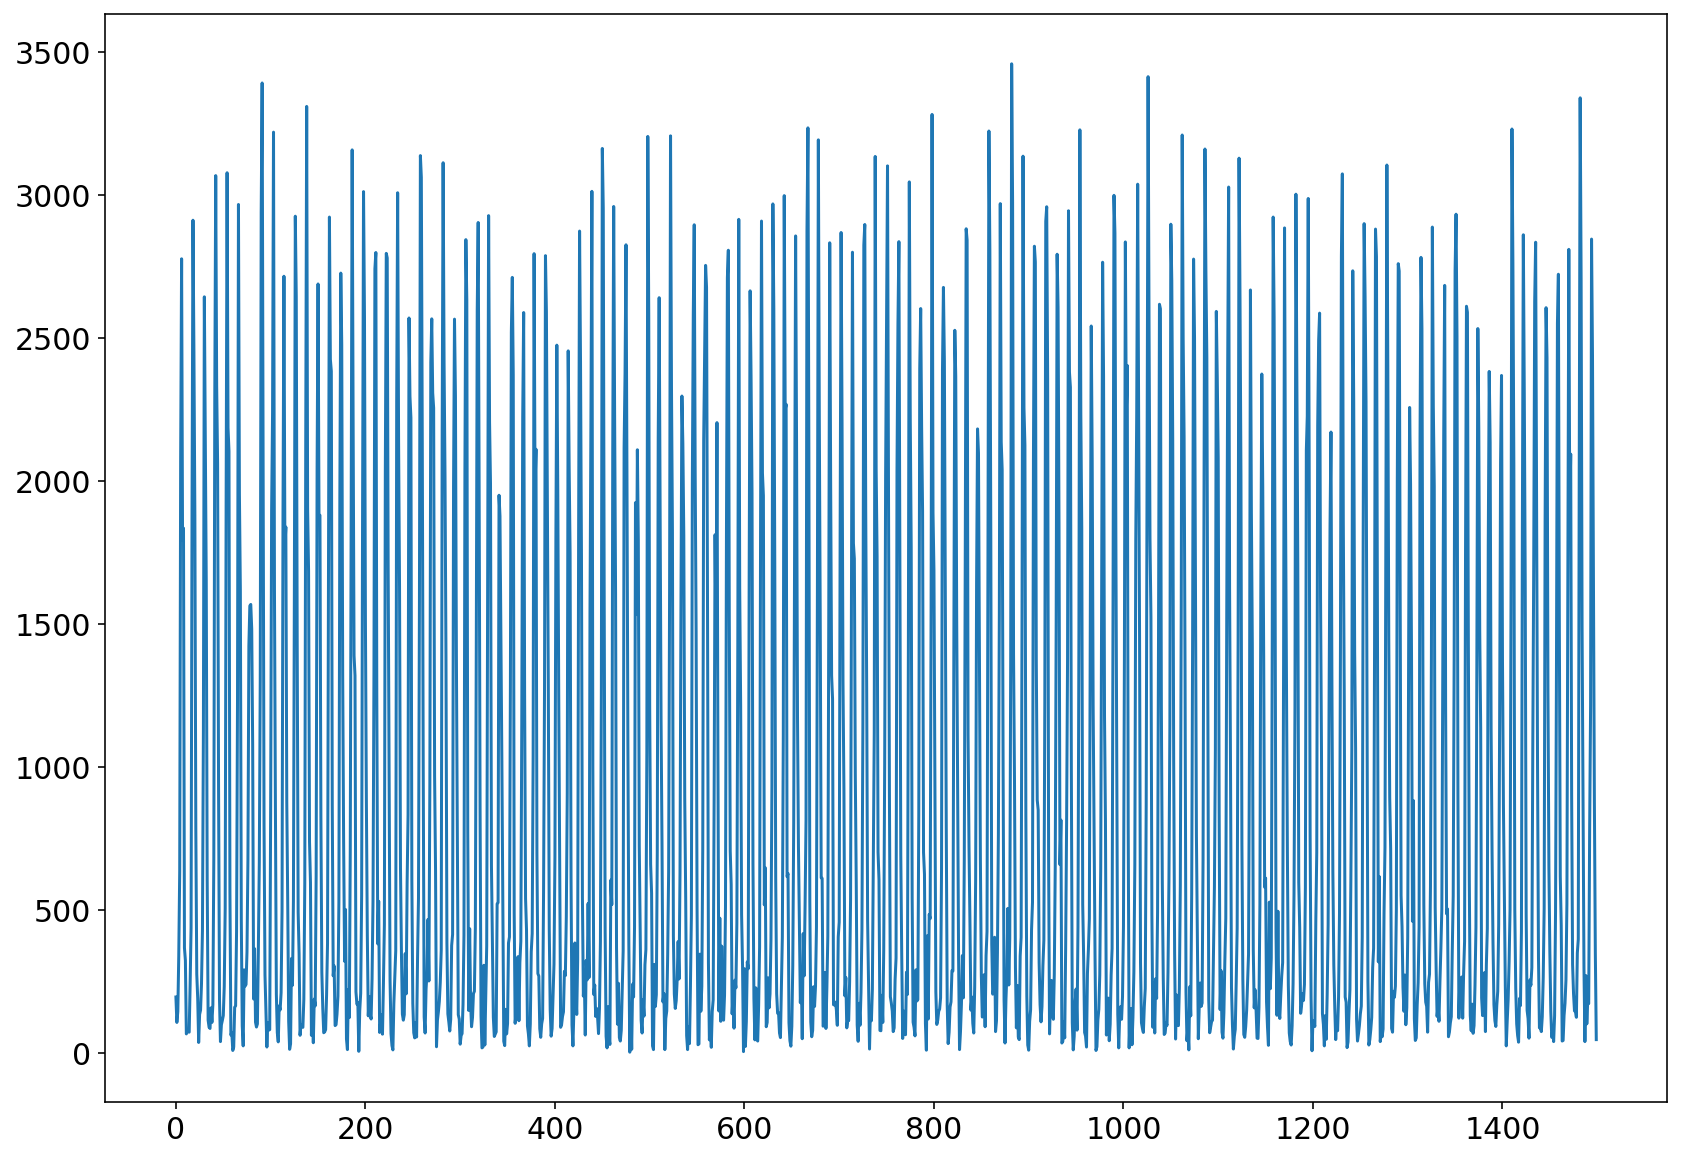

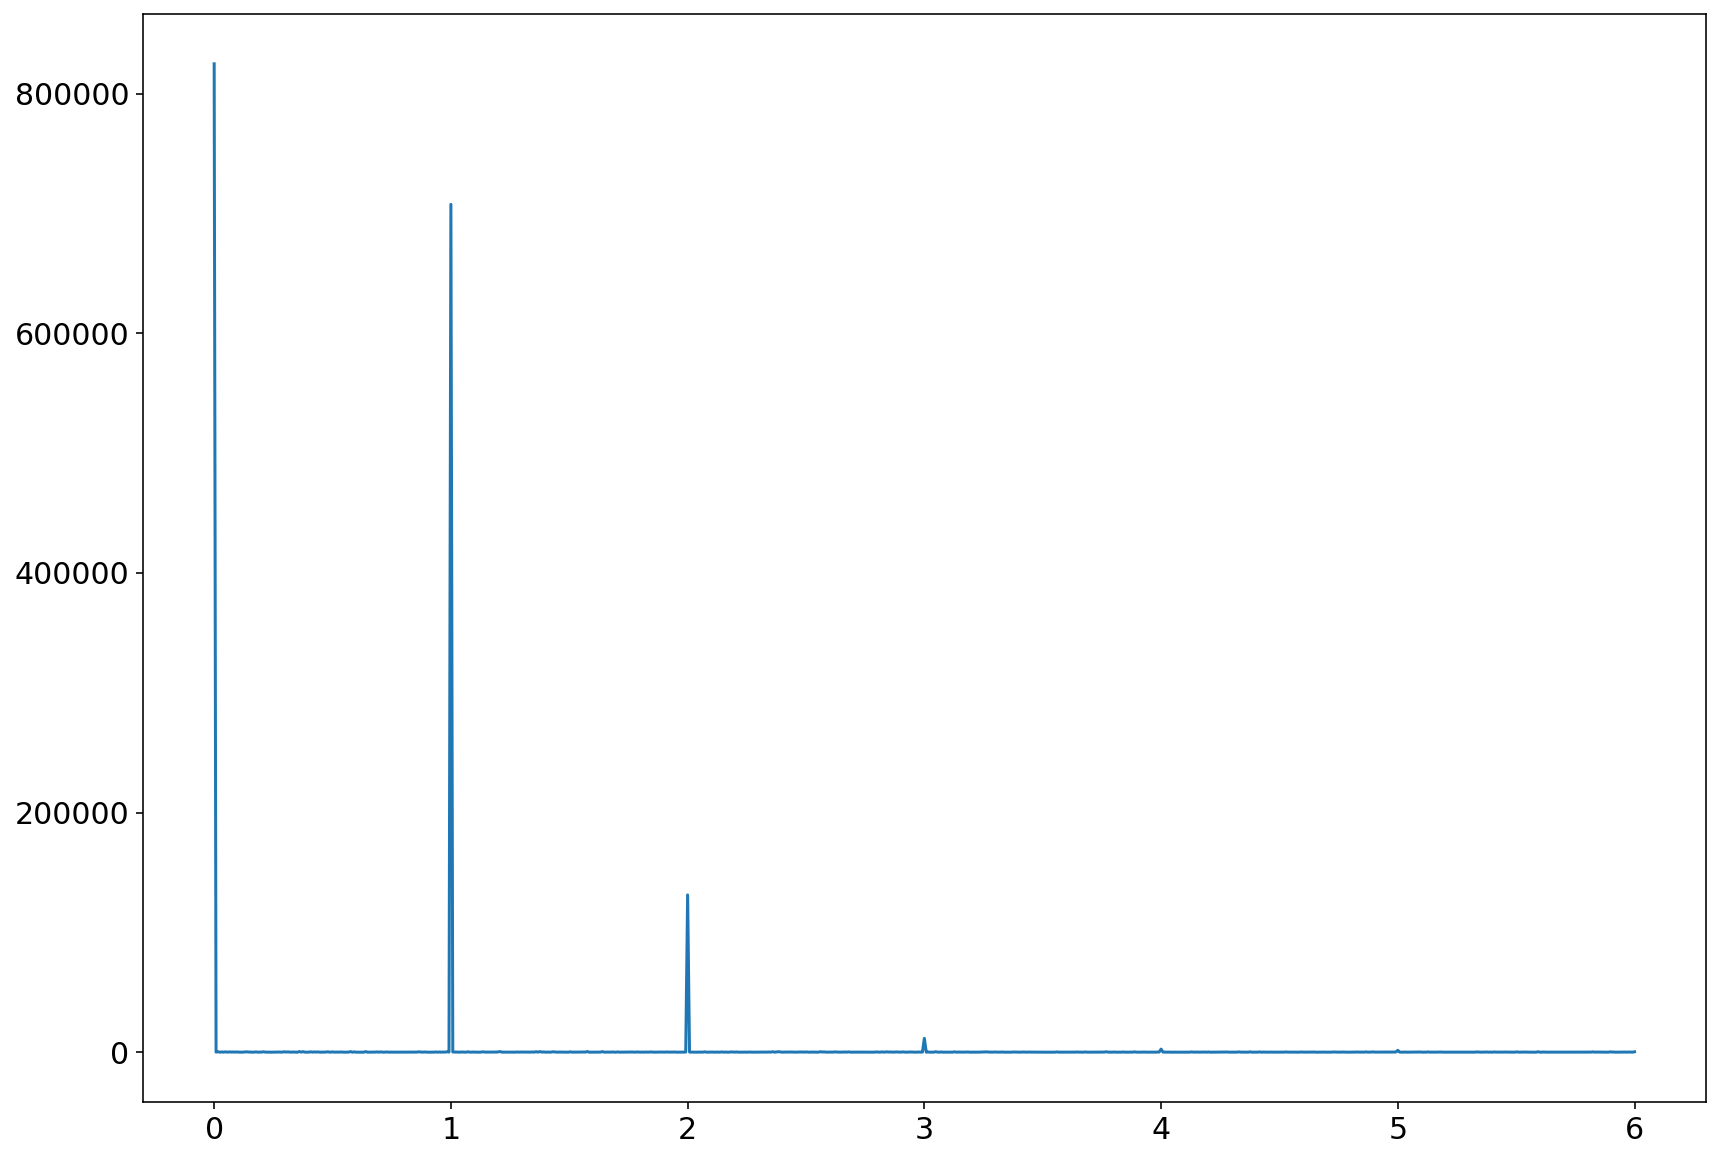

In [166]:
filepath = "data/rain_m.txt"

rain_df = pd.read_csv(filepath, sep = '\t', header=None)
rain = []
for i in range(146):
    rain = rain + [m for m in rain_df.iloc[i]] 

SIZE = 1500;
rain_m = np.array(rain[:SIZE])
plt.plot(rain_m);
plt.show()
y = periodogram(rain_m, fs = 12, detrend=False, scaling='spectrum')
plt.plot(y[0], y[1]);

In [6]:
# t = (np.sin(np.arange(SIZE) * 2 * np.pi / (T + 0.1*np.sin(2*np.pi*np.arange(SIZE)/2500)) ) + 1.6 * np.sin(np.arange(SIZE) * 2 * np.pi / (T+2 +0.1*np.sin(2*np.pi*np.arange(SIZE)/2000)))) * ( \
# np.cos(np.arange(SIZE) * 2 * np.pi / (144*3)) + 5)
# x = periodogram(t)
# plt.plot(x[0], x[1])

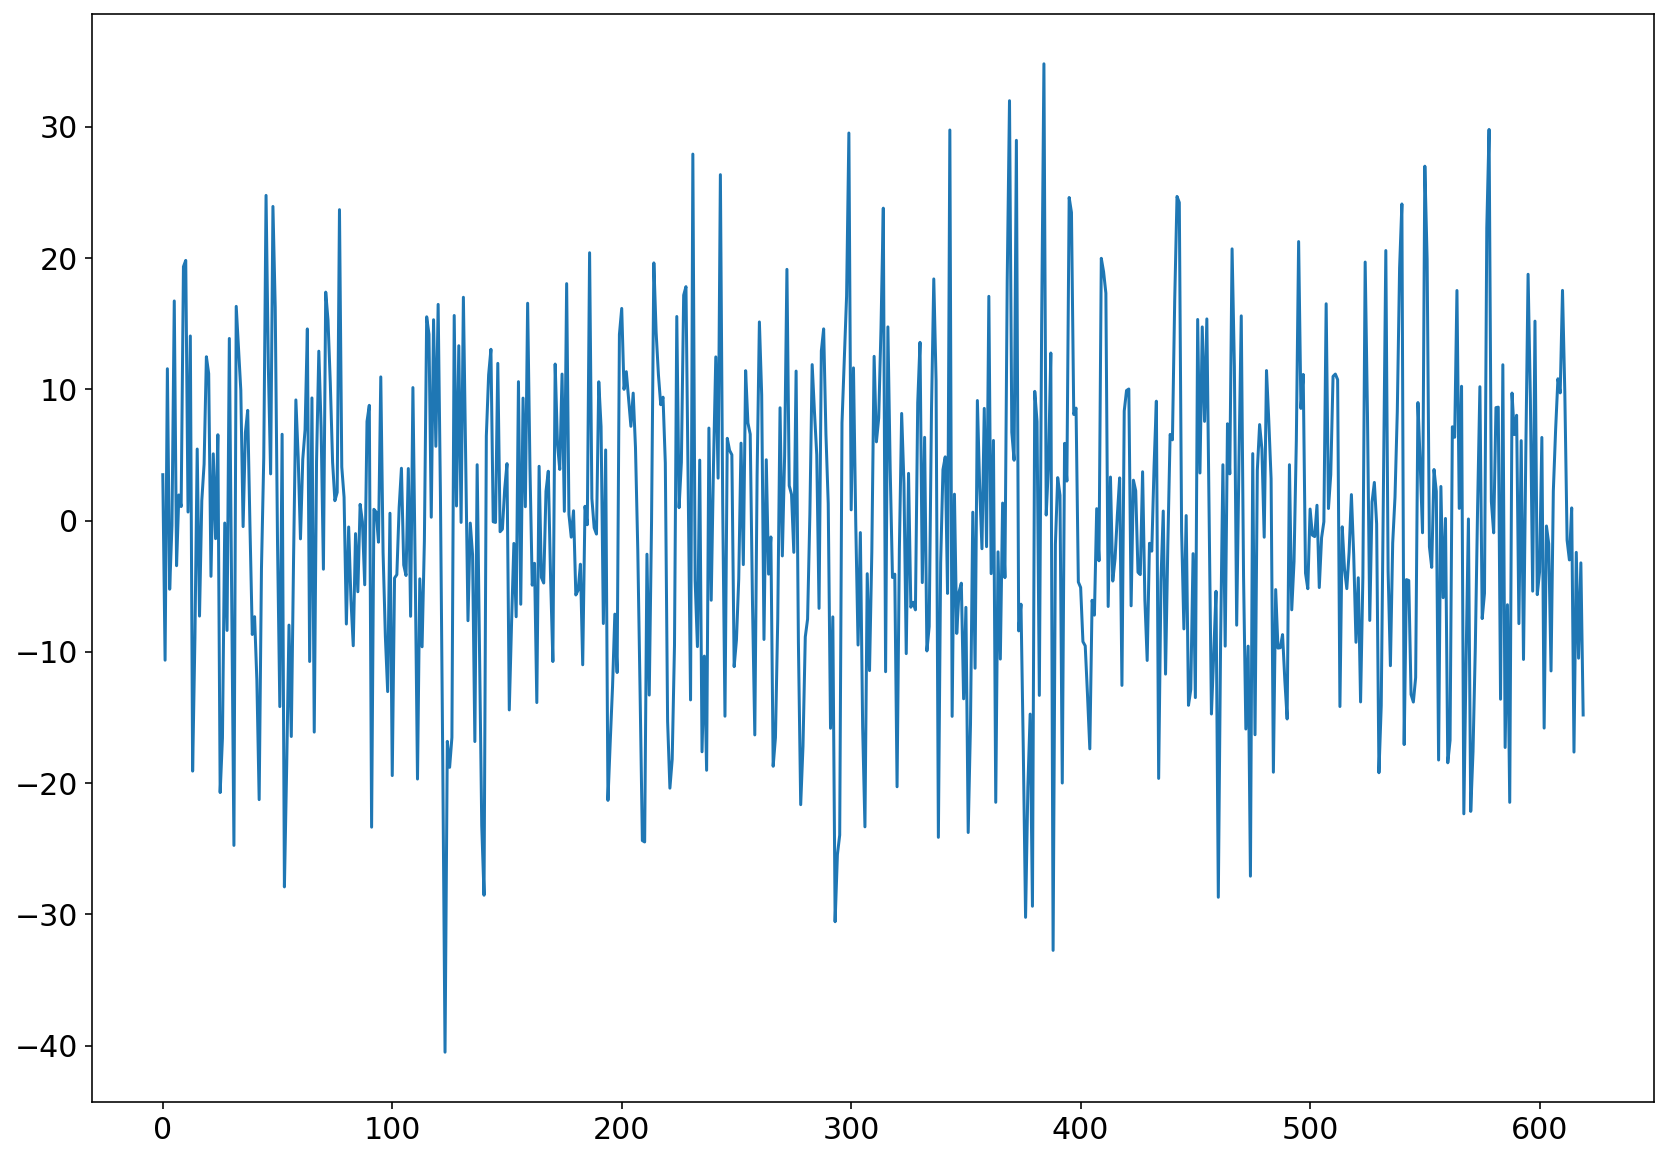

620

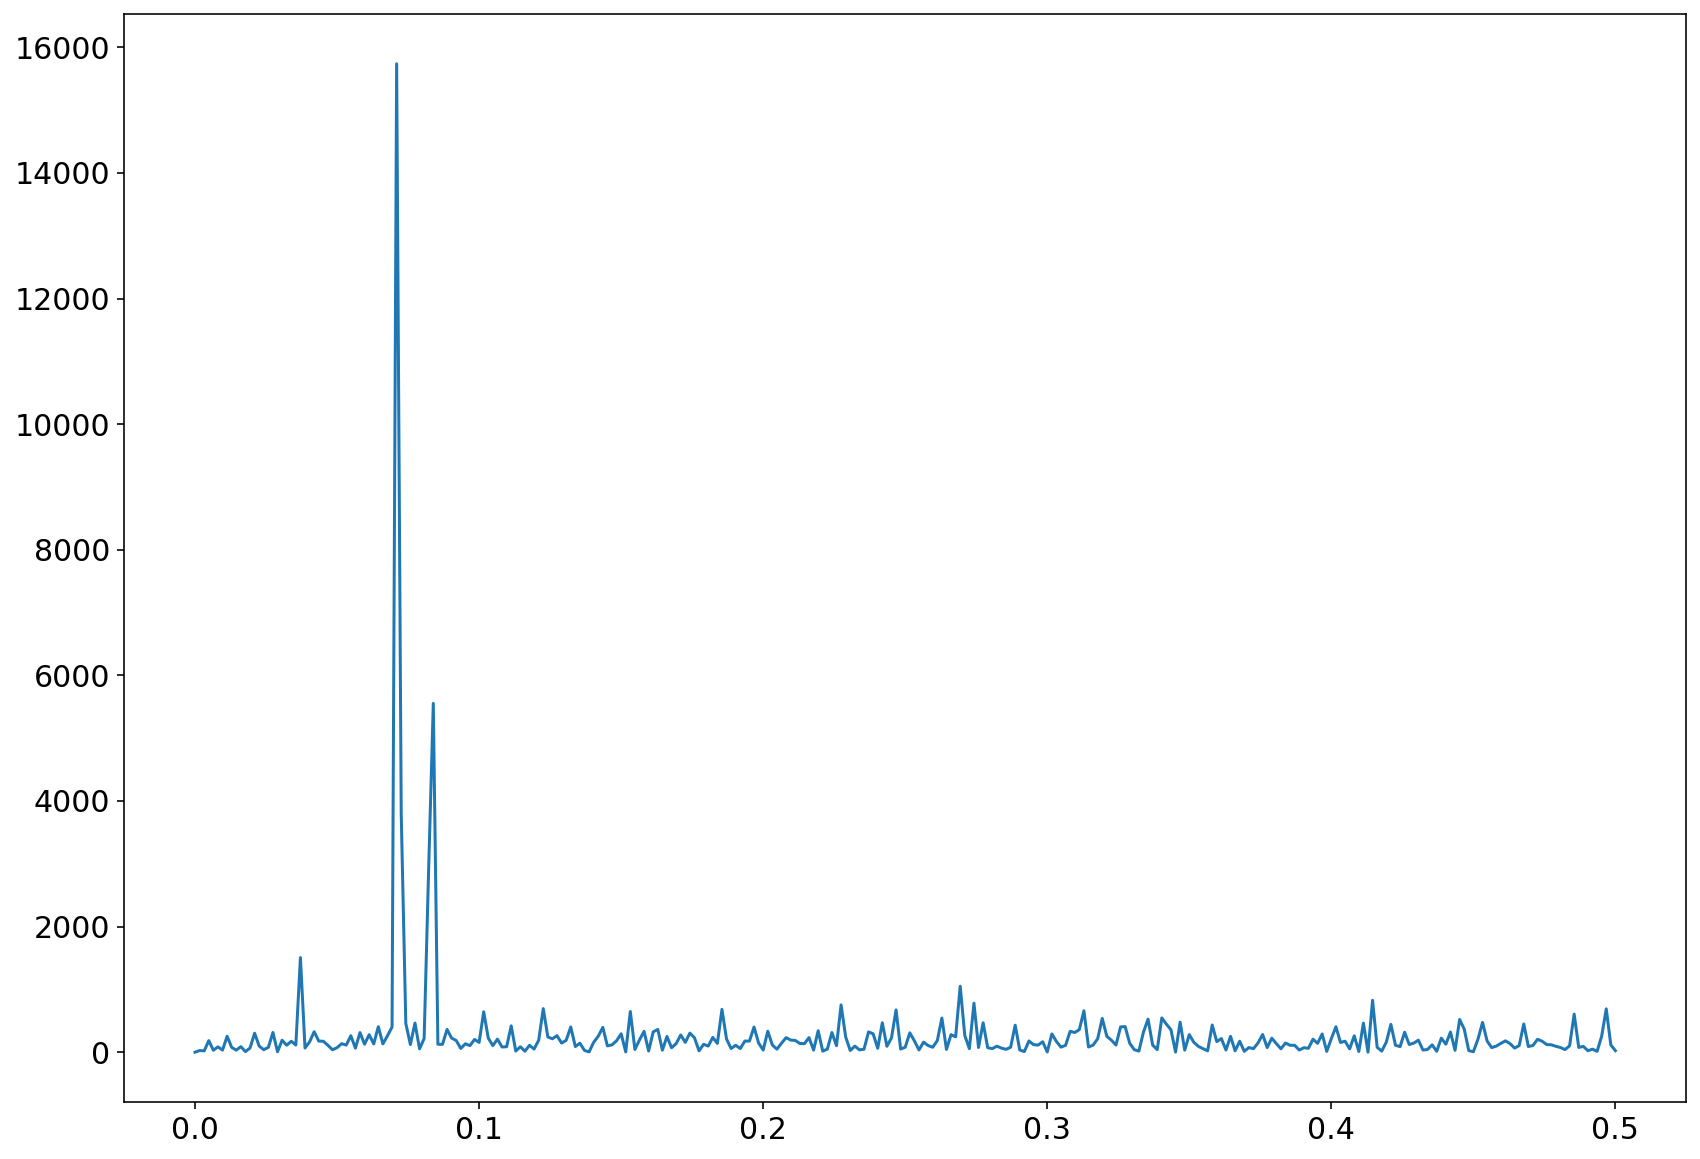

In [53]:
# sin
SIZE = 1500;
np.random.seed(RANDOM_SEED)
T = 12

#tsSin_sig = np.sin(np.arange(SIZE) * 2 * np.pi / T)
tsSin_sig = (np.sin(np.arange(SIZE) * 2 * np.pi / T) + 1.6 * np.sin(np.arange(SIZE) * 2 * np.pi / (T+2))) * ( \
np.cos(np.arange(SIZE) * 2 * np.pi / (144*3)) + 5)

tsSin = tsSin_sig + np.sqrt((tsSin_sig**2).mean() / 0.5) * np.random.normal(size=SIZE) #np.sqrt((tsSin_sig**2).mean() / 0.5) 
tsSin = tsSin[40:660]
plt.plot(tsSin);
SIZE = len(tsSin)
plt.show()
y = periodogram(tsSin)
plt.plot(y[0], y[1]);
SIZE

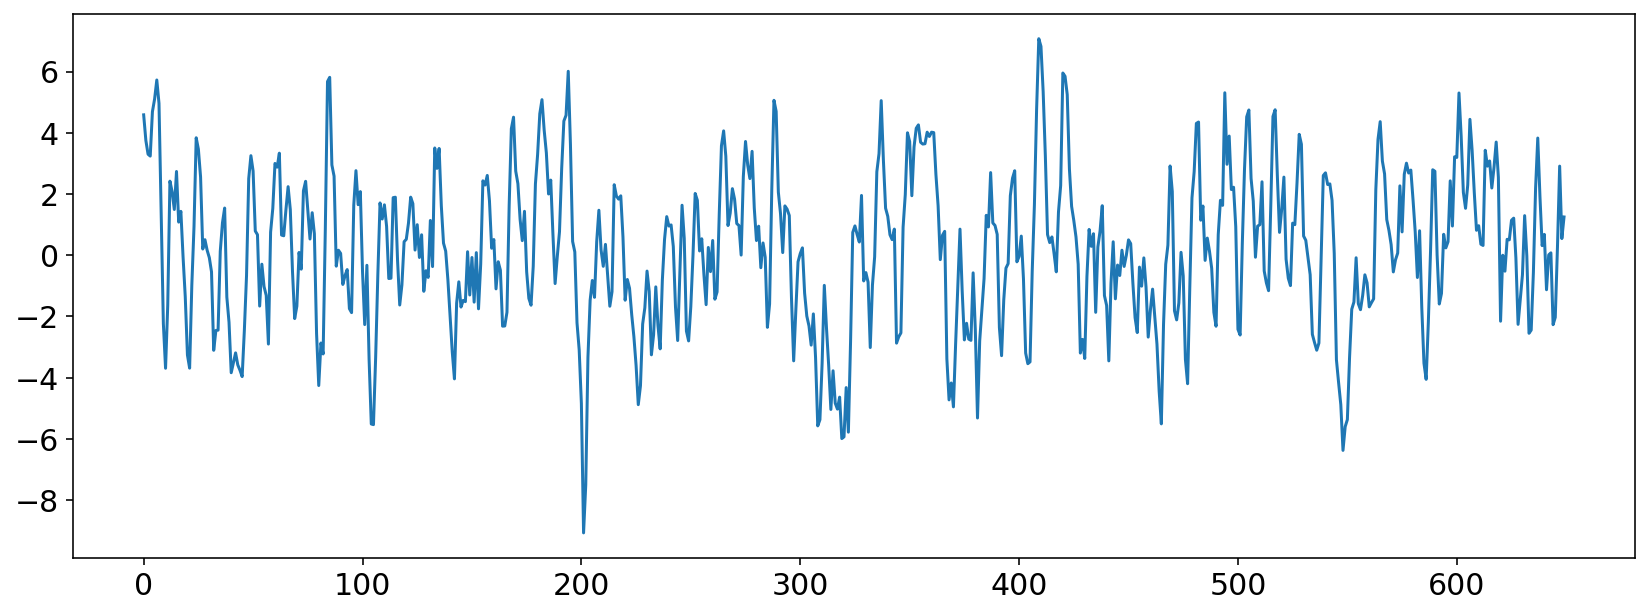

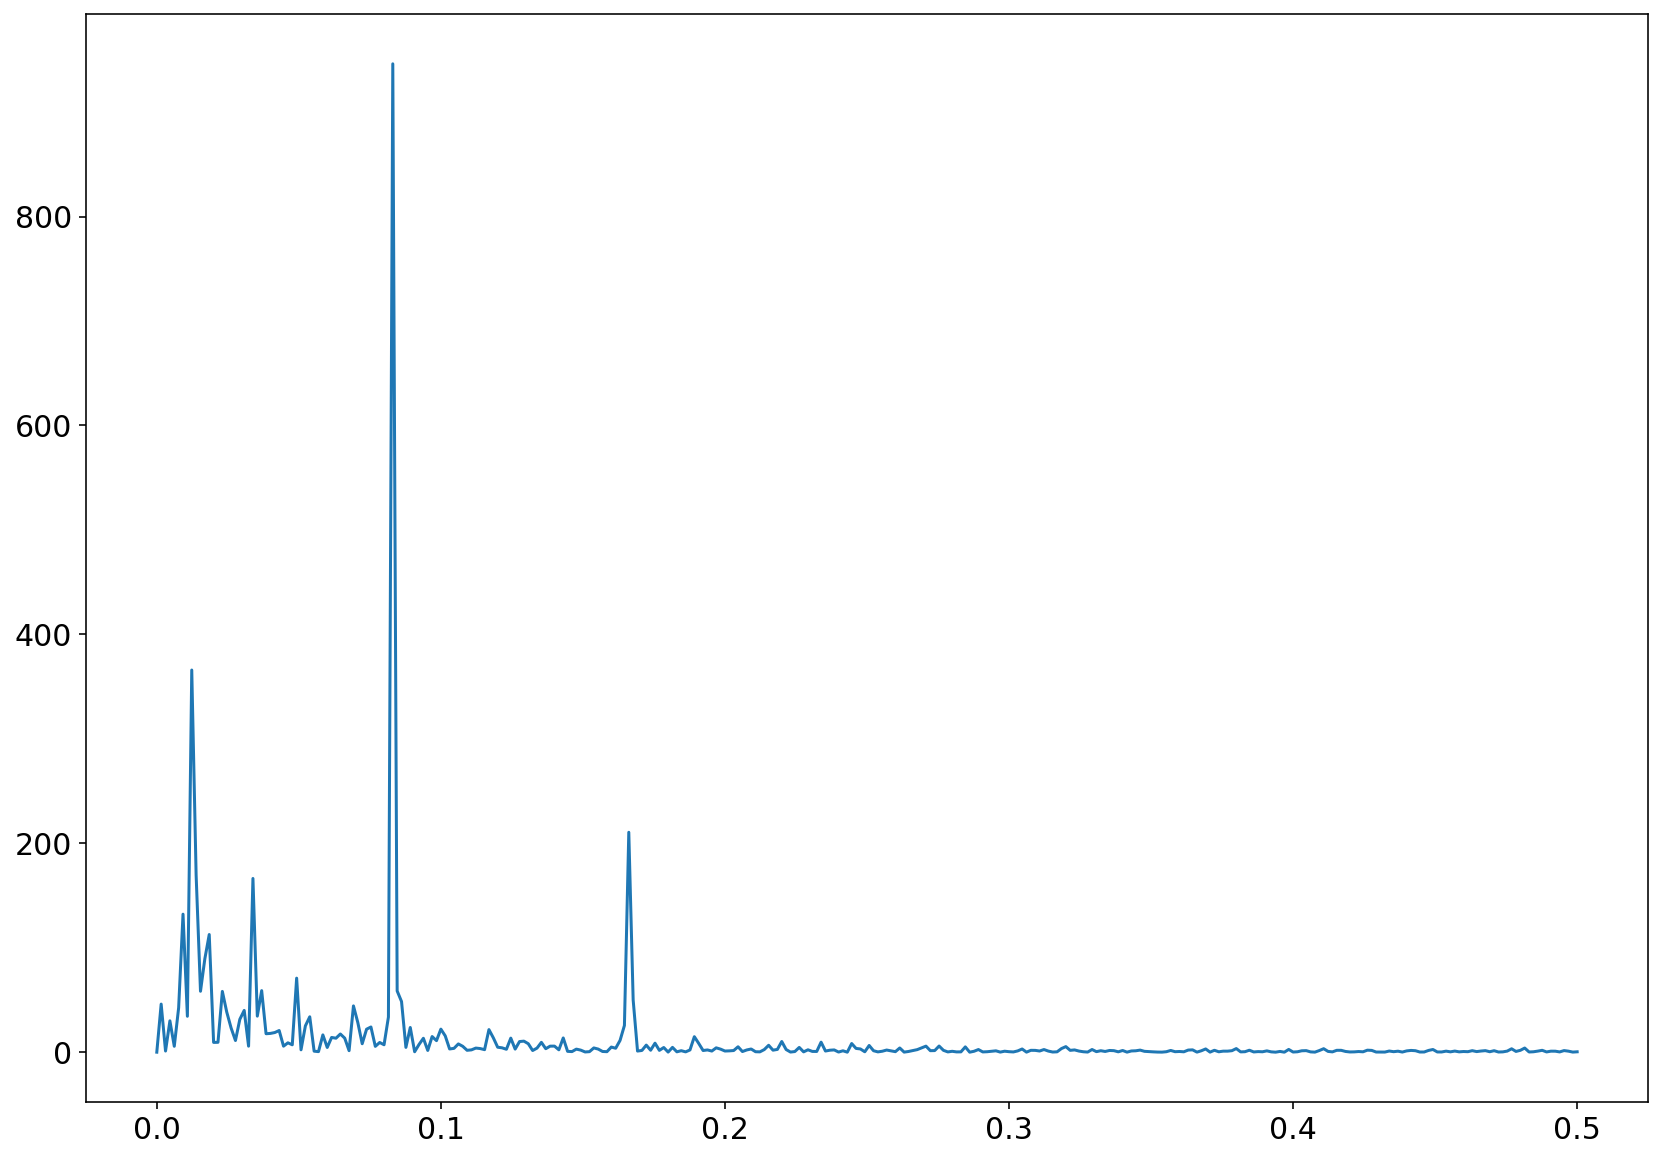

In [5]:
np.random.seed(RANDOM_SEED)
ser_rnoise = pd.read_csv('data/ser.csv',)['x'].to_numpy()
ser_sig = pd.read_csv('data/ser_sig.csv',)['x'].to_numpy()

SIZE = len(ser_sig)

# ts trigger
ser = ser_rnoise
# ser = ser_sig + 0.3 * np.random.normal(size=SIZE)

plt.figure(figsize=(14, 5))
rc('xtick', labelsize=15) 
rc('ytick', labelsize=15) 
plt.plot(ser);
SIZE = len(ser)
plt.show()

y = periodogram(ser)
plt.plot(y[0], y[1])

# plt.figure(figsize=(14, 5))
# rc('xtick', labelsize=15) 
# rc('ytick', labelsize=15) 
# plt.plot(ser[:TRAIN_SIZE]);
# plt.plot(applySSA(ser[:TRAIN_SIZE], ssa), color = 'red')

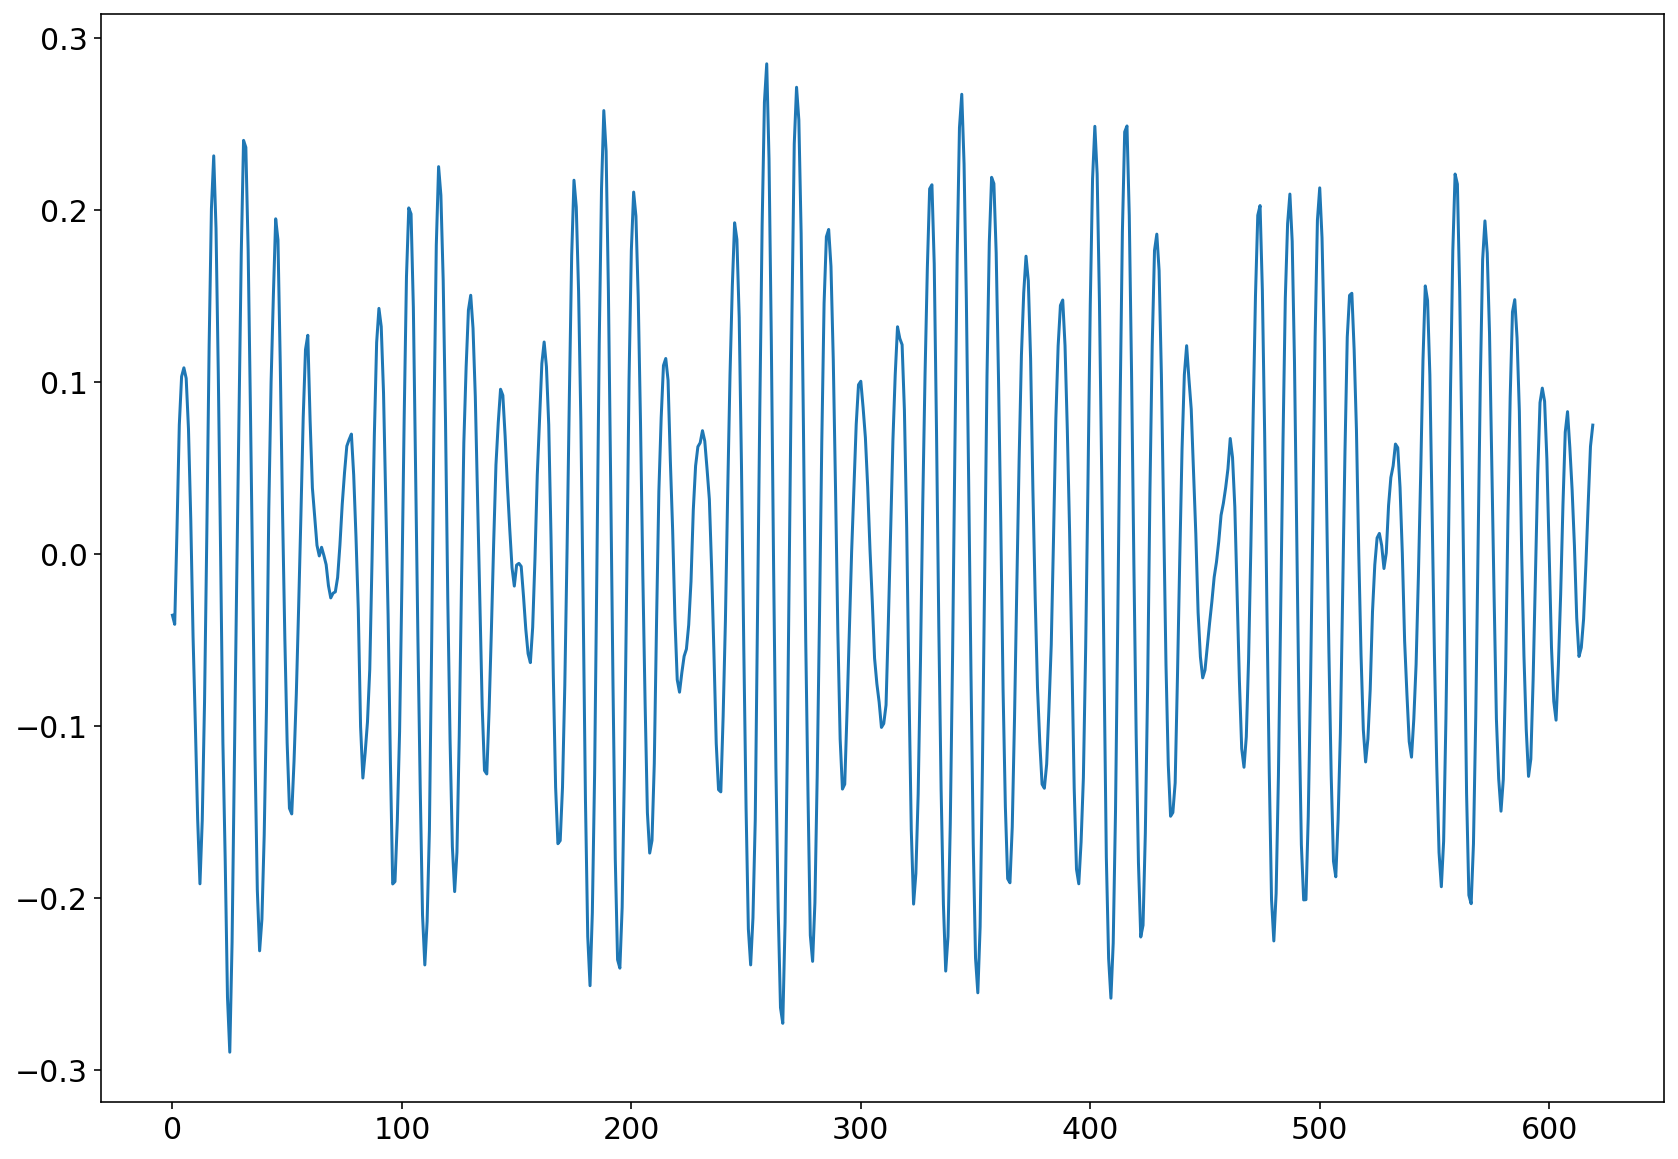

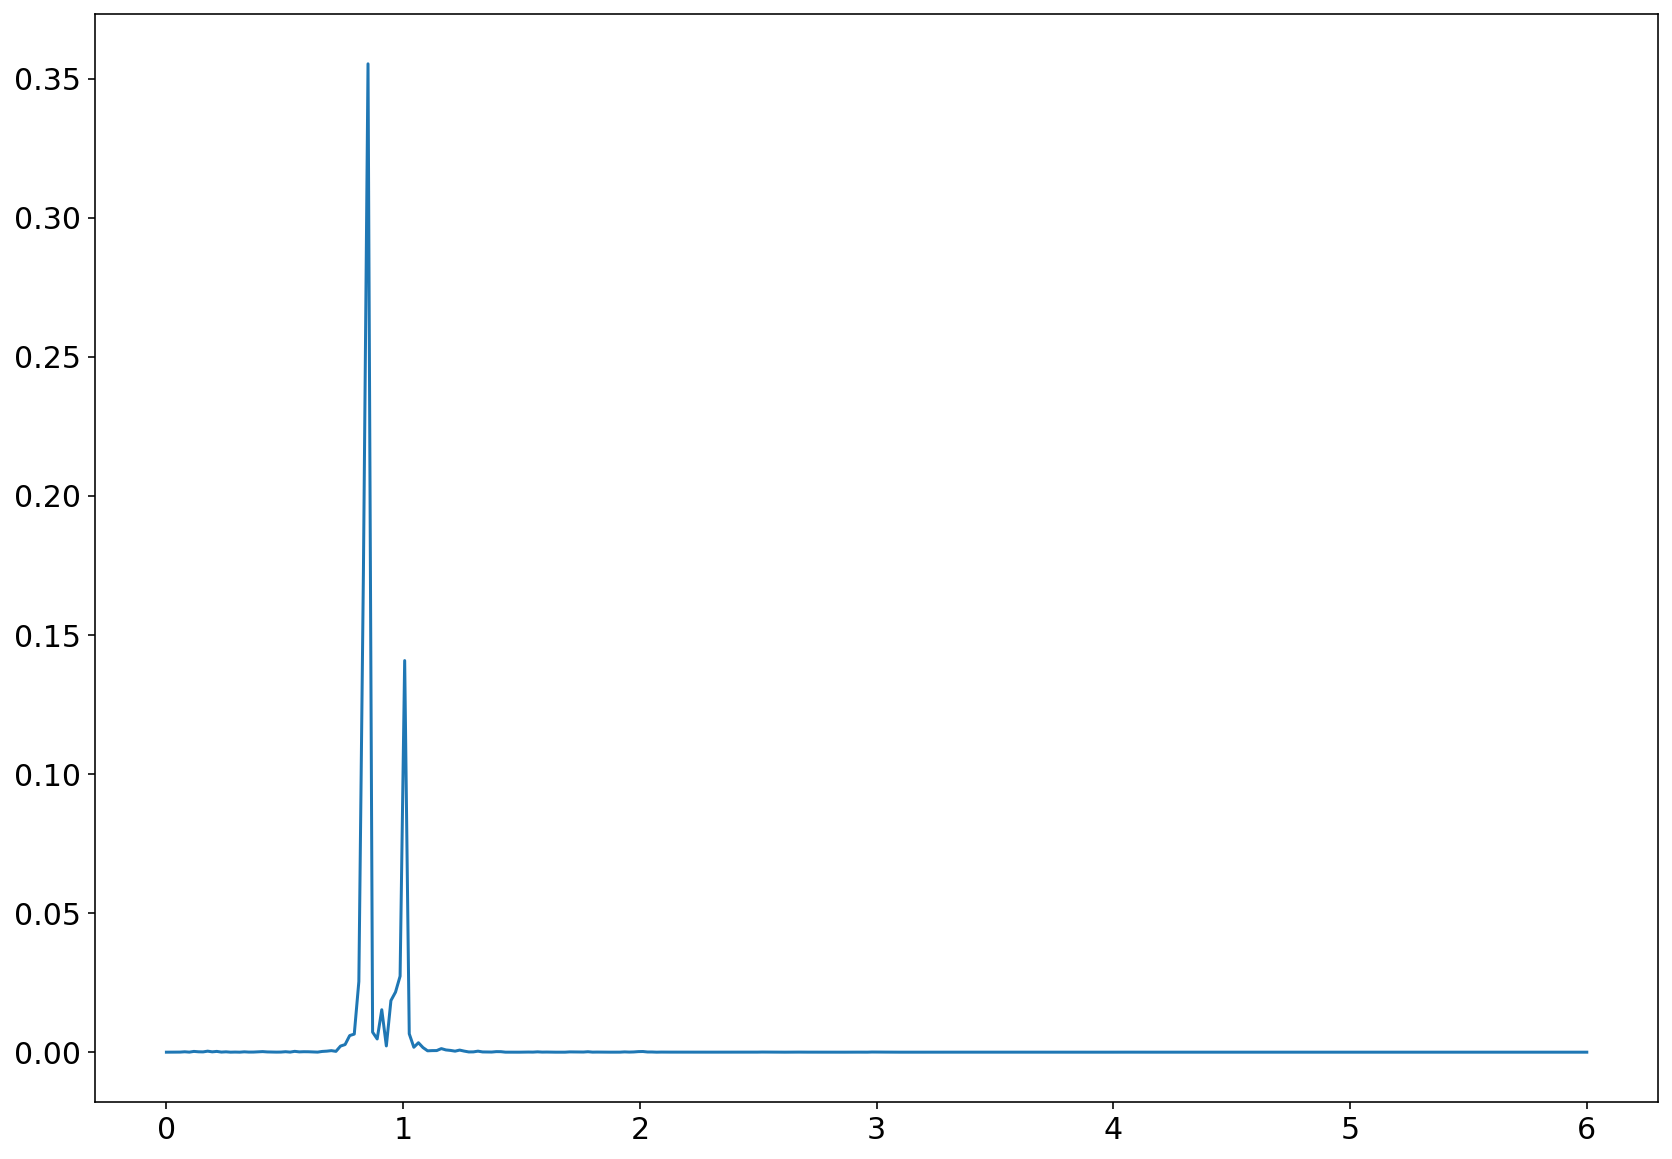

In [155]:
# EOP x_pole; TODO: cut till 620
x_pole_ts = pd.read_csv('data/x_no_trend.csv',)['ts_x'].to_numpy()[:620]
plt.plot(x_pole_ts);
SIZE = len(x_pole_ts)
plt.show()
y = periodogram(x_pole_ts, detrend = False, fs = 12)
plt.plot(y[0], y[1]);

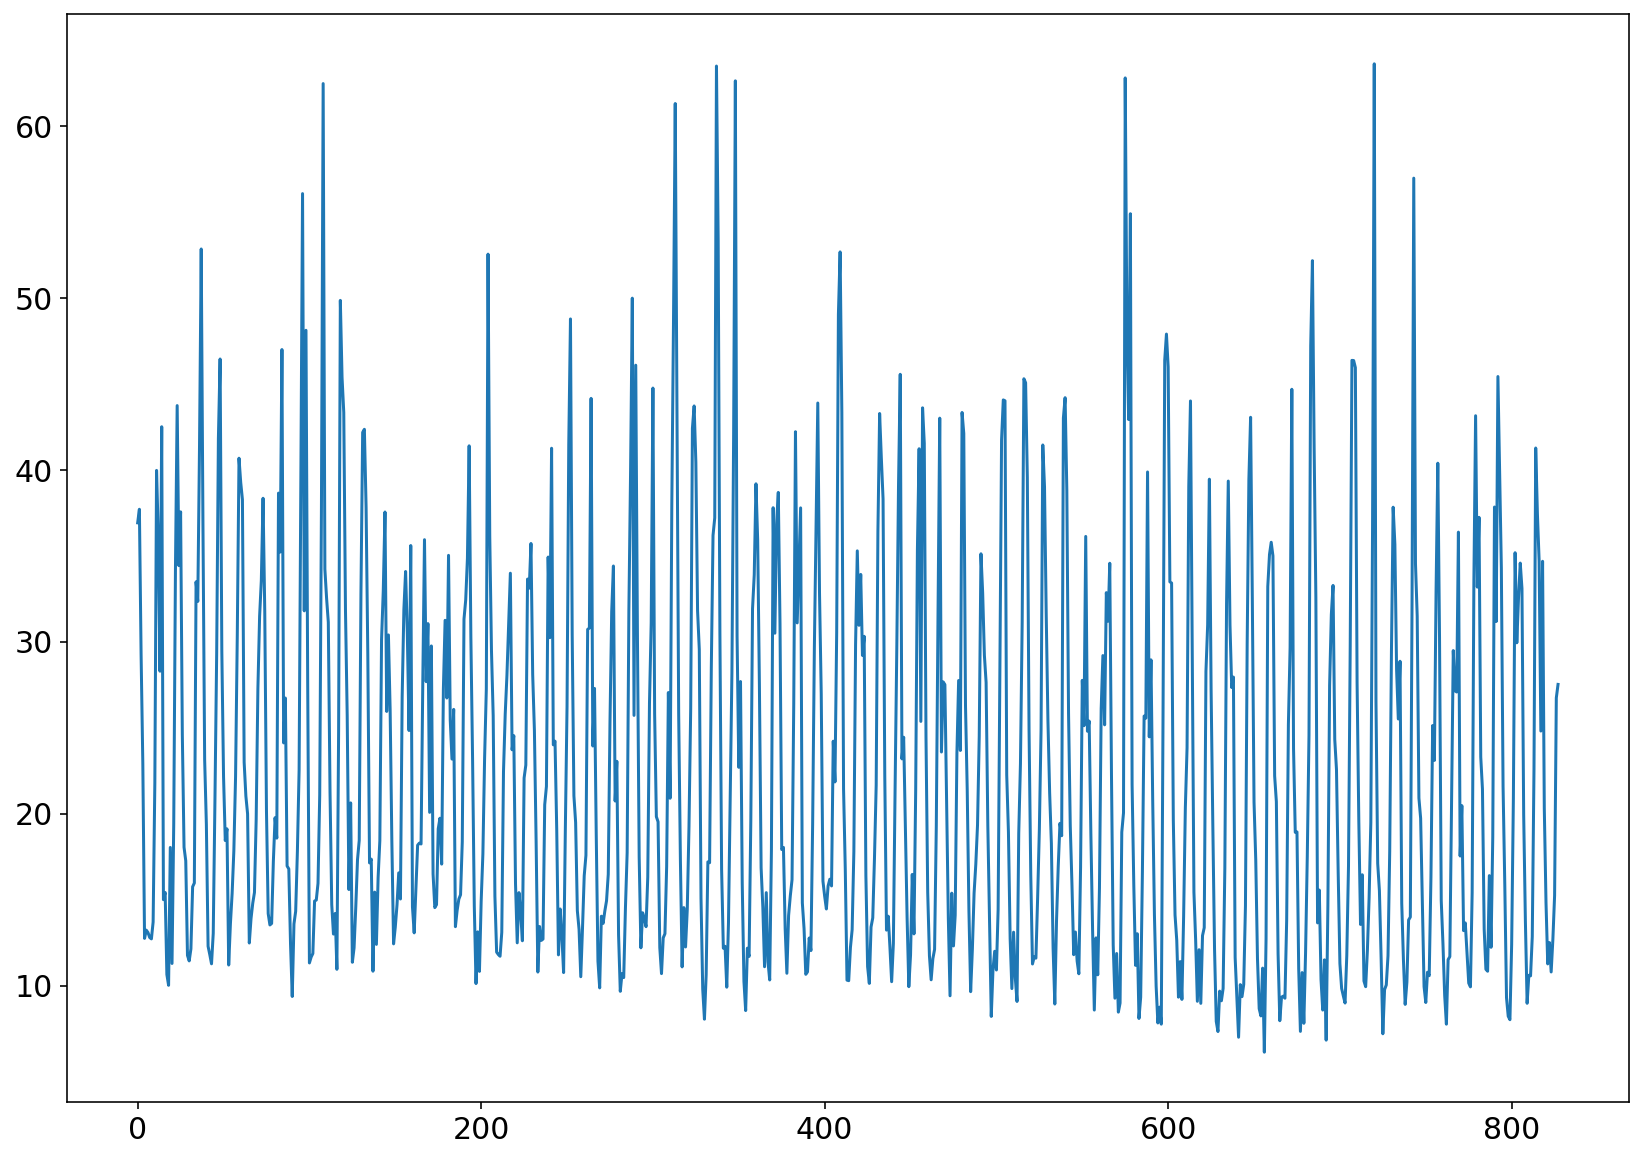

828

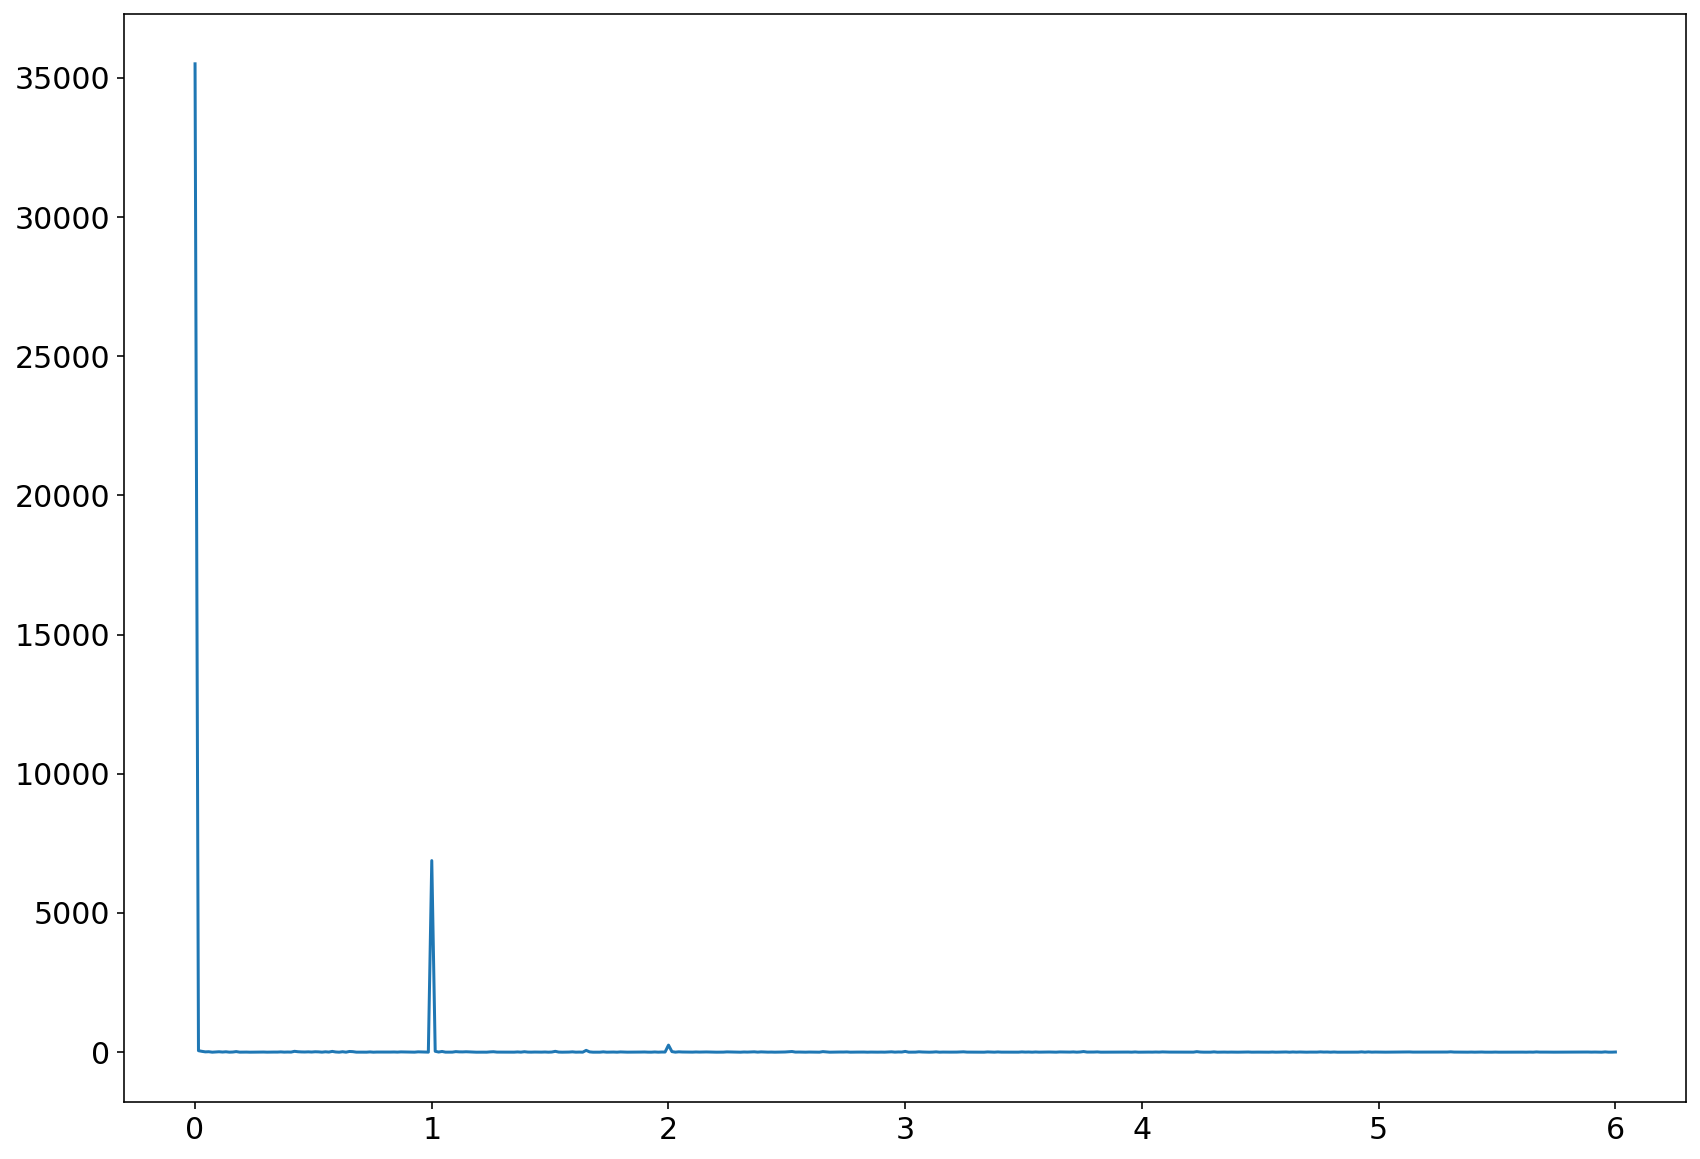

In [177]:
weather7 = np.load('data/weather4.npy', allow_pickle=True)
weather7 = weather7.astype(np.float64)
SIZE = len(weather7)
plt.plot(weather7);
plt.show()
y = periodogram(weather7, detrend = False, fs = 12)
plt.plot(y[0], y[1]);
SIZE

In [6]:
# TRAIN_SIZE, VAL_SIZE, TEST_SIZE = 320, 150, 150;
TRAIN_SIZE, VAL_SIZE, TEST_SIZE = 350, 150, 150;
# TRAIN_SIZE, VAL_SIZE, TEST_SIZE = 750, 500, 250;
# TRAIN_SIZE, VAL_SIZE, TEST_SIZE = 528, 150, 150;
seq_len = 48;

assert TRAIN_SIZE + VAL_SIZE + TEST_SIZE == SIZE, "wrong TRAIN and VAL sizes"

ssa = edict({
    'L' : TRAIN_SIZE//2,
    'ssa_groups' : list(range(1,3)), #[1,2,3,4,5,6,7],
    'rssa' : rssa
})

# split_data
#data = splitData(rain_m, seq_len, TRAIN_SIZE, VAL_SIZE, TEST_SIZE, ssa, val_ssa = False)
#data_sig = splitData(tsSin_sig, seq_len, TRAIN_SIZE, VAL_SIZE, TEST_SIZE, ssa, val_ssa = False)

In [26]:
# train_ds = Dataset(data.train.X, data.train.y.reshape(-1, 1))
# valid_ds = Dataset(data.val.X, data.val.y.reshape(-1, 1))
#valid_ds_ssa = Dataset(data.val.X_ssa, data.val.y.reshape(-1, 1))

# GridSearchCV for NNs

In [7]:
def createFolder(path):
    try:
        os.mkdir(path)
    except OSError as e:
        print("Ошибка %s" % e)
    except FileExistsError:
        print(f"File {path} already exists")
        
def makePrediction(net, data, bSSA):
    if bSSA:
        seq = applySSA(data.ts[:data.train.size], ssa)
        seq = seq[-data.seq_len:]
        preds = getPredsTomorrow(
              net.module_.to('cpu')
            , seq
            , data.val.ts_ssa
            , data.scaler_ssa
            , VAL_SIZE
            , data.seq_len
            , verbose = False
            )
    else:
        preds = getPredsTomorrow(
                net.module_.to('cpu')
              , data.ts[:TRAIN_SIZE][-data.seq_len:]
              , data.ts[TRAIN_SIZE : (TRAIN_SIZE+VAL_SIZE)] 
              , data.scaler
              , VAL_SIZE
              , data.seq_len
              , verbose = False
              )
 
    pc = data.scaler.inverse_transform(
            np.expand_dims(preds, axis=0)
              ).flatten()
    return pc
 
def searchBestSeriesValueByGrid(splitter, models, folder, T_lens, hl_lens, RANDOM_SEED, bSSA = False, iterations = 1, signal = None):
    path = 'data/results/'
 
    if bSSA:
        path += 'SSA/'
 
    # splitter = DataSplitter(time_series, TRAIN_SIZE, VAL_SIZE, TEST_SIZE, ssa, val_ssa = bSSA)
 
 
    for T in T_lens:
        #createFolder(f'{path}{folder}/{str(T)}')
 
        data = splitter.split(T)
        if bSSA:
 
            valid_ds = Dataset(data.val.X_ssa, data.val.y.reshape(-1, 1))
        else:
            valid_ds = Dataset(data.val.X, data.val.y.reshape(-1, 1))
 
 
        for model in models:
            prev_res = None
            try:
                prev_res = pd.read_csv(f'{path}{folder}/{model[1]}.csv', sep = ';')
            except OSError:
                pass
 
 
            lResults = []
            best_score = 100000
            
            for hl in hl_lens:
                lIterRes = []
                for it in range(iterations):
                    net = NeuralNetRegressor( model[0]
                                  , module__input_size = T if model[1] == 'ann' else 1 
                                  , module__hidden_size = hl
                                  , module__output_size = 1
                                  #, module__device = device
 
 
                                  , callbacks = [
                                                MyEarlyStopping(monitor='valid_loss', patience = 50) 
                                  ]
                                  , train_split= predefined_split(valid_ds)
                                  , max_epochs = 5000
                                  , optimizer=torch.optim.Adam
                                  , lr=0.001
                                  , batch_size = -1
                                  , verbose=0
                                  , device = device
                                  , criterion = torch.nn.modules.loss.MSELoss
                                  #, optimizer__weight_decay=0.01
                                  )
                    
                    torch.manual_seed(RANDOM_SEED + it)
 
                    if bSSA:
                        net.fit(data.train.X_ssa, data.train.y.reshape(-1, 1))
                    else:
                        net.fit(data.train.X, data.train.y.reshape(-1, 1))
 
                    # test fold is used.
                    pc = getPredCases(net.module_.to('cpu'), data, tomorrow = True, y_ssa=False, ssa = None if bSSA is False else ssa)
                    rmse_value = getRMSE(data.ts[-TEST_SIZE:], pc)
                    if signal is None:
                        cols = ['rmse', 'hl', 'T', 'RS', 'preds']
                        lResults.append([rmse_value, hl, T, RANDOM_SEED + it, " ".join(list(map(lambda x: str(x), pc)))])
                    else:
                        cols = ['rmse', 'rmse_signal', 'hl', 'T', 'RS', 'preds']
                        rmse_value_signal = getRMSE(signal, pc)
                        lResults.append([rmse_value, rmse_value_signal, hl, T, RANDOM_SEED + it, " ".join(list(map(lambda x: str(x), pc)))])
                    # Val only.
                    #pc = makePrediction(net, data, bSSA)
                    #rmse_value = getRMSE(data.ts[TRAIN_SIZE:(TRAIN_SIZE+VAL_SIZE)], pc)
                    #lIterRes.append(getRMSE(data.ts[TRAIN_SIZE:(TRAIN_SIZE+VAL_SIZE)], pc))
 
                #lResults.append( lIterRes )
            curr_res = pd.DataFrame(lResults, columns = cols)
            if prev_res is not None:
                curr_res = pd.concat([prev_res, curr_res], ignore_index=True, sort=False)
            curr_res.to_csv(f'{path}{folder}/{model[1]}.csv', sep = ';', index=False)
            #with open(f'{path}{folder}/{str(T)}/{model[1]}_series.txt', 'w') as f:
            #    for item in lResults:
            #        f.write("%s\n" % item)
 
            print(f"Saved: {model[1]}, {T}. Time: {datetime.datetime.now()}")
    
class DataSplitter:
    def __init__(self, ts, TRAIN_SIZE, VAL_SIZE, TEST_SIZE, ssa, val_ssa):
        self.val_ssa = val_ssa
 
        self.TRAIN_SIZE = TRAIN_SIZE
        self.VAL_SIZE = VAL_SIZE
        self.TEST_SIZE = TEST_SIZE
 
        #Scalers
        self.scaler = StandardScaler()
        self.scaler_ssa = StandardScaler()
 
        self.tsOrigin = ts
 
        self.dTrain = ts[:TRAIN_SIZE]
        self.scaler = self.scaler.fit(np.expand_dims(self.dTrain, axis=1))
        self.dVal = ts[TRAIN_SIZE:(TRAIN_SIZE+VAL_SIZE)]
        self.dTest = ts[(TRAIN_SIZE+VAL_SIZE):]
 
        self.dTrain_ssa = applySSA(self.tsOrigin[:TRAIN_SIZE], ssa)
        self.scaler_ssa = self.scaler_ssa.fit(np.expand_dims(self.dTrain_ssa, axis=1))
        self.dVal_ssa = None
        self.dTest_ssa = None
        if self.val_ssa:
            dVal_and_Test_ssa = createTestTsSSA(self.tsOrigin, VAL_SIZE + TEST_SIZE, ssa)
 
            assert VAL_SIZE + TEST_SIZE == len(dVal_and_Test_ssa), "wrong TRAIN and VAL sizes"
 
            self.dVal_ssa = dVal_and_Test_ssa[:VAL_SIZE]
            self.dTest_ssa = dVal_and_Test_ssa[VAL_SIZE:]
 
    def split(self, seq_len):
 
        ts = self.scaler.transform(np.expand_dims(self.tsOrigin, axis=1)).squeeze()
        dTrain = self.scaler.transform(np.expand_dims(self.dTrain, axis=1)).squeeze()
        dVal = self.scaler.transform(np.expand_dims(self.dVal, axis=1)).squeeze()
        dTest = self.scaler.transform(np.expand_dims(self.dTest, axis=1)).squeeze()
 
 
 
        dTrain_ssa = self.scaler_ssa.transform(np.expand_dims(self.dTrain_ssa, axis=1)).squeeze()
        if self.val_ssa:
            dVal_ssa = self.scaler_ssa.transform(np.expand_dims(self.dVal_ssa, axis=1)).squeeze()
            dTest_ssa = self.scaler_ssa.transform(np.expand_dims(self.dTest_ssa, axis=1)).squeeze()
 
 
        X_train, y_train = create_sequences(dTrain, seq_len)
        X_val, y_val = create_sequences(dVal, seq_len)
        X_test, y_test = create_sequences(dTest, seq_len)
 
        X_train_ssa, y_train_ssa = create_sequences(dTrain_ssa, seq_len)
        X_val_ssa = None
        y_val_ssa = None
        ts_val_ssa = None
        ts_test_ssa = None
 
        if self.val_ssa:
            X_val_ssa, y_val_ssa = create_sequences(dVal_ssa, seq_len)
            X_val_ssa = torch.from_numpy(X_val_ssa).float()
            y_val_ssa = torch.from_numpy(y_val_ssa).float()
            ts_val_ssa = self.dVal_ssa
            ts_test_ssa = self.dTest_ssa
 
        data = {
          'train' : {
            'ts' : dTrain,
            'X' : torch.from_numpy(X_train).float(),
            'X_ssa' : torch.from_numpy(X_train_ssa).float(),
            'y' : torch.from_numpy(y_train).float(),
            'y_ssa' : torch.from_numpy(y_train_ssa).float(),
            'size' : self.TRAIN_SIZE
          },
          'val' : {
            'ts' : dVal,
            'X' : torch.from_numpy(X_val).float(),
            'X_ssa' : X_val_ssa,
            'y' : torch.from_numpy(y_val).float(),
            'y_ssa' : y_val_ssa,
            'size' : self.VAL_SIZE,
            'ts_ssa' : ts_val_ssa
          },
          'test' : {
            'ts' : dTest,
            'X' : torch.from_numpy(X_test).float(),
            'y' : torch.from_numpy(y_test).float(),
            'size' : self.TEST_SIZE,
            'ts_ssa' : ts_test_ssa
          },
          'ts_scaled' : ts,
          'ts' : self.tsOrigin,
          'seq_len' : seq_len,
          'scaler' : self.scaler,
          'scaler_ssa' : self.scaler_ssa
      }
        data = edict(data)
 
        return data

In [8]:
models = [(FCModel, 'ann')
            , (RNN, 'rnn')
            , (GRU, 'gru')
            , (LSTM, 'lstm')]

([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 84)

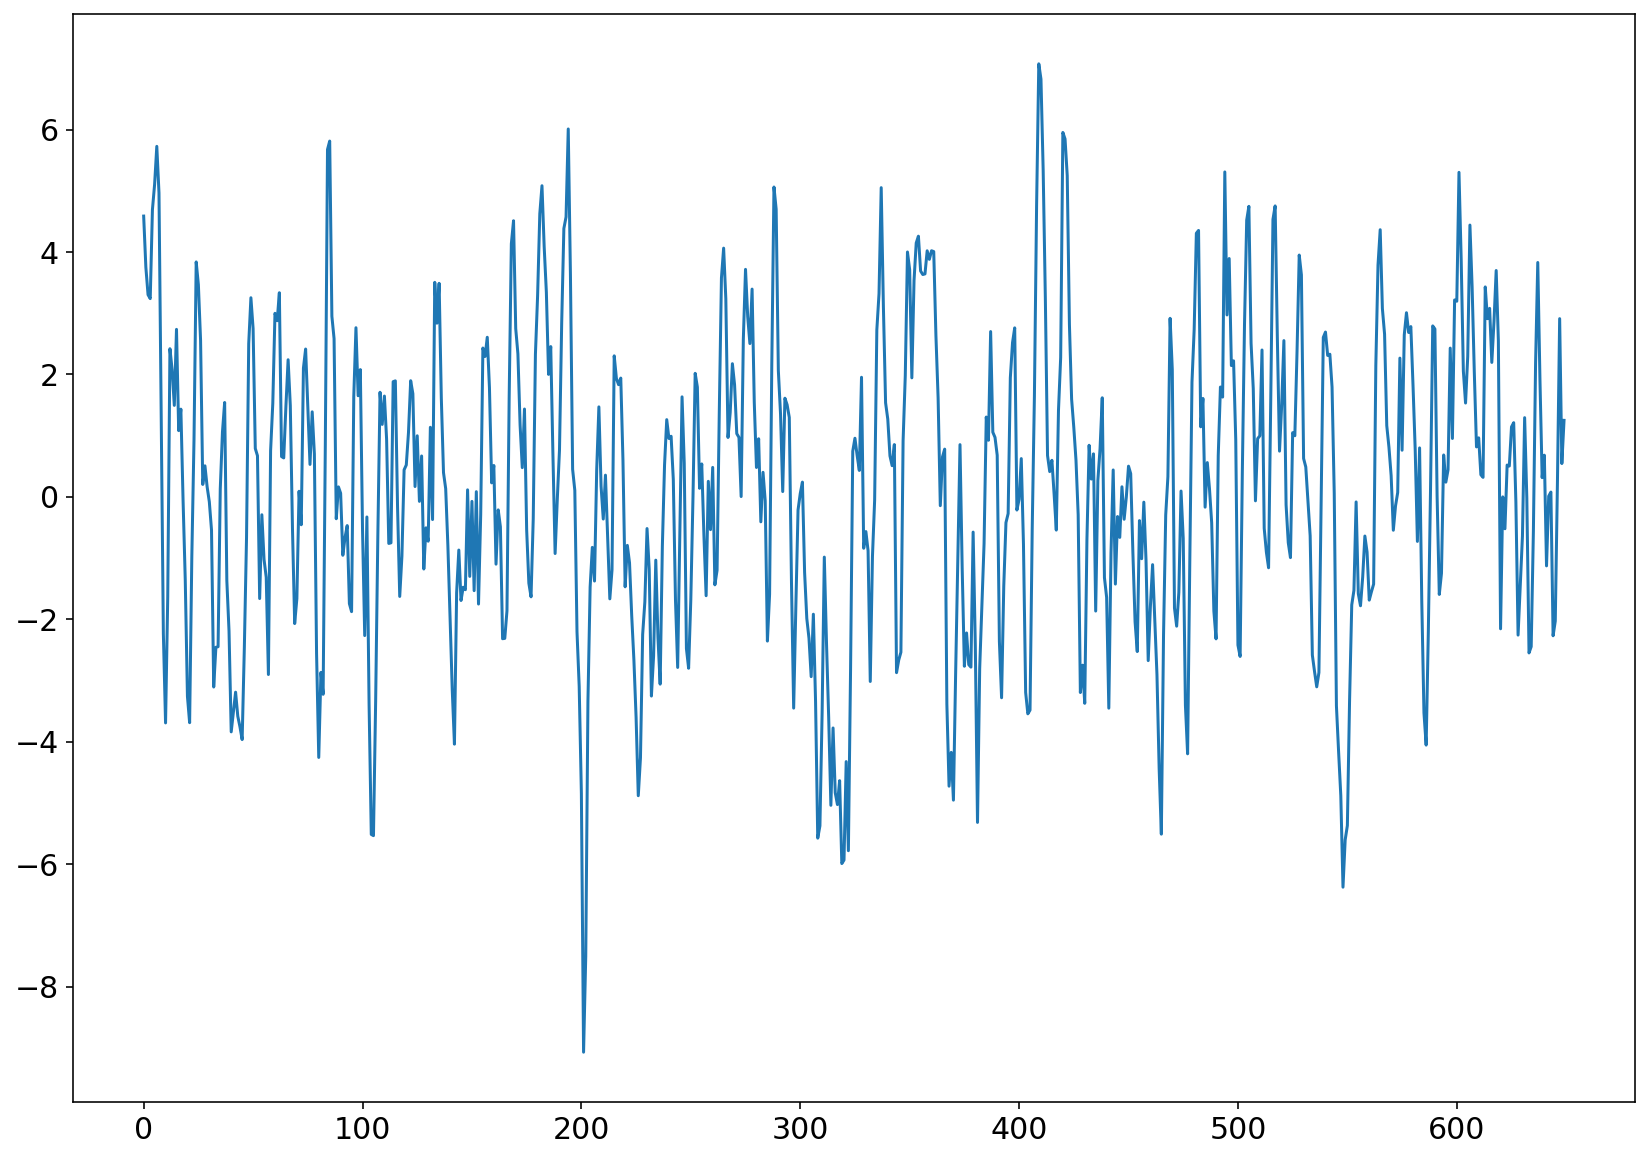

In [36]:
Ls = list(range(12, 150, 12))
# Ls = list(range(13, 150, 39))
Ls = [12, 84]
Hs = list(range(10, 101, 15))
folder = 'ser'
time_series = ser
plt.plot(time_series)
ssa.ssa_groups, ssa.L

In [37]:
splitter = DataSplitter(time_series, TRAIN_SIZE, VAL_SIZE, TEST_SIZE, ssa, val_ssa = False)

In [38]:
searchBestSeriesValueByGrid(splitter, models, folder, Ls, Hs, 
                            RANDOM_SEED = RANDOM_SEED, bSSA = False, iterations = 7)

Saved: ann, 12. Time: 2022-05-17 11:21:21.528856
Saved: rnn, 12. Time: 2022-05-17 11:23:51.540125
Saved: gru, 12. Time: 2022-05-17 11:26:24.871567
Saved: lstm, 12. Time: 2022-05-17 11:28:24.331501
Saved: ann, 84. Time: 2022-05-17 11:28:48.546272
Saved: rnn, 84. Time: 2022-05-17 11:31:37.567369
Saved: gru, 84. Time: 2022-05-17 11:34:32.540823
Saved: lstm, 84. Time: 2022-05-17 11:39:16.866066


In [27]:
folder = 'ser/r2loops'
ssa = edict({
    'L' : TRAIN_SIZE//2,
    'ssa_groups' : list(range(1,3)), #[1,2,3,4,5,6,7],
    'rssa' : rssa
})

In [28]:
splitter = DataSplitter(time_series, TRAIN_SIZE, VAL_SIZE, TEST_SIZE, ssa, val_ssa = True)

100%|█████████████████████████████████████████████████████████████████████████████████| 300/300 [00:11<00:00, 25.47it/s]


In [29]:
searchBestSeriesValueByGrid(splitter, models, folder, Ls, Hs, 
                            RANDOM_SEED = RANDOM_SEED, bSSA = True, iterations = 7)

Saved: ann, 12. Time: 2022-05-17 10:38:15.150001
Saved: rnn, 12. Time: 2022-05-17 10:39:36.403916
Saved: gru, 12. Time: 2022-05-17 10:41:06.090306
Saved: lstm, 12. Time: 2022-05-17 10:42:31.652535
Saved: ann, 84. Time: 2022-05-17 10:42:58.218090
Saved: rnn, 84. Time: 2022-05-17 10:44:28.399017
Saved: gru, 84. Time: 2022-05-17 10:46:27.083747
Saved: lstm, 84. Time: 2022-05-17 10:48:25.617621


In [30]:
folder = 'ser/r4loops'
ssa = edict({
    'L' : TRAIN_SIZE//2,
    'ssa_groups' : list(range(1,5)), #[1,2,3,4,5,6,7],
    'rssa' : rssa
})

In [31]:
splitter = DataSplitter(time_series, TRAIN_SIZE, VAL_SIZE, TEST_SIZE, ssa, val_ssa = True)

100%|█████████████████████████████████████████████████████████████████████████████████| 300/300 [00:12<00:00, 23.17it/s]


In [32]:
searchBestSeriesValueByGrid(splitter, models, folder, Ls, Hs, 
                            RANDOM_SEED = RANDOM_SEED, bSSA = True, iterations = 7)

Saved: ann, 12. Time: 2022-05-17 10:49:26.647167
Saved: rnn, 12. Time: 2022-05-17 10:50:38.283872
Saved: gru, 12. Time: 2022-05-17 10:52:04.524330
Saved: lstm, 12. Time: 2022-05-17 10:53:36.859476
Saved: ann, 84. Time: 2022-05-17 10:54:11.165895
Saved: rnn, 84. Time: 2022-05-17 10:56:03.207007
Saved: gru, 84. Time: 2022-05-17 10:58:43.425222
Saved: lstm, 84. Time: 2022-05-17 11:00:57.940054


In [33]:
folder = 'ser/r14loops'
ssa = edict({
    'L' : 84,
    'ssa_groups' : list(range(1,15)), #[1,2,3,4,5,6,7],
    'rssa' : rssa
})

In [34]:
splitter = DataSplitter(time_series, TRAIN_SIZE, VAL_SIZE, TEST_SIZE, ssa, val_ssa = True)

100%|█████████████████████████████████████████████████████████████████████████████████| 300/300 [00:09<00:00, 30.80it/s]


In [35]:
searchBestSeriesValueByGrid(splitter, models, folder, Ls, Hs, 
                            RANDOM_SEED = RANDOM_SEED, bSSA = True, iterations = 7)

Saved: ann, 12. Time: 2022-05-17 11:03:40.095780
Saved: rnn, 12. Time: 2022-05-17 11:05:39.636700
Saved: gru, 12. Time: 2022-05-17 11:07:50.637359
Saved: lstm, 12. Time: 2022-05-17 11:10:17.288458
Saved: ann, 84. Time: 2022-05-17 11:10:46.162508
Saved: rnn, 84. Time: 2022-05-17 11:13:31.286884
Saved: gru, 84. Time: 2022-05-17 11:16:54.316724
Saved: lstm, 84. Time: 2022-05-17 11:19:23.595239


***

# SSA

In [13]:
def grid_search_ssa_params(train: np.array, val: np.array, L: list, r: list, methods: list, rssa: object) -> tuple:
    print(f'Всего {len(L) * len(r) * len(methods) } различных моделей.')
    rmse_error_best = 1000000000
    L_best = None
    r_best = None
    method_best = None
    results = []
    
    for method_curr in methods:
        for L_curr in L:
            for r_curr in r:
                if (L_curr >= r_curr):
                    try:
                        preds = predict_array_by_ssa(train, val, L_curr, r_curr, method_curr, rssa)
                        rmse_error = np.sqrt(((preds.reshape(-1) - val)**2).mean())
                    except Exception as e:
                        rmse_error = 0
                        print(e)
                        
                    results.append((rmse_error, L_curr, r_curr, method_curr))
                    
                    if (rmse_error < rmse_error_best):
                        L_best = L_curr
                        r_best = r_curr
                        method_best = method_curr
                        rmse_error_best = rmse_error
    
    return ((L_best, r_best, method_best), rmse_error_best, results)

def search_ssa_params(folder: str, path: str = 'data/ssa_res/',  **kwargs) -> tuple:
    results = grid_search_ssa_params(**kwargs)
    dfRes = pd.DataFrame(results[2], columns = ['rmse', 'L', 'r', 'method'])
    dfRes = dfRes.sort_values('rmse')
    
    if folder[-1] != '/':
        folder += '/'
    dfRes.to_csv(f'{path}{folder}results.csv', sep = ';', index=False)
    
    with open(f'{path}{folder}info.txt', 'w') as f:
        f.write(f"TRAIN_SIZE: {len(kwargs['train'])} \n")
        f.write(f"L list: {kwargs['L']} \n")
        f.write(f"r list: {kwargs['r']} \n \n")
        
        f.write(f"Best L: {results[0][0]} \n")
        f.write(f"Best r: {results[0][1]} \n")
        f.write(f"Best method: {results[0][2]} \n")
        f.write(f"Error: {results[1]} \n")
    return results

def predict_onepoint_by_ssa(seq: np.array, L: int, r: list, method: str, rssa: object):
    s = rssa.ssa(seq, kind='1d-ssa', L=L);
    res = rssa.rforecast(s, groups = robjects.r(f'list(1:{r})'), len = 1)
    #resD = dict(zip(res.names, list(res)))
    #pp = reduce(lambda x,y: x + y, list(resD['mean']))[0]"
    
    return res

def predict_array_by_ssa(seq: np.array, array: np.array, L: int, r: list, method: str, rssa: object) -> np.array:
    preds = []
    for value in array:
        preds.append(predict_onepoint_by_ssa(seq, L, r, method, rssa))
        seq = np.append(seq[1:], value)
    return np.array(preds)

def grid_search_ssa_params_seq(train: np.array, val: np.array, seq_L: list, r: list, methods: list, bL = False) -> tuple:
    print(f'Всего {len(seq_L) * len(r) * len(methods) } различных моделей.')
    rmse_error_best = 1000000000
    L_best = None
    r_best = None
    method_best = None
    results = []
    
    
    for method_curr in methods:
        for seq_curr in seq_L:
            seq = train[-seq_curr:]
            for r_curr in r:
                if bL:
                    Ls = np.arange(bL, len(seq)//2, bL)
                    if r_curr == 12:
                        Ls = np.arange(bL*2, len(seq)//2, bL)
                    for L in Ls:
                        preds = predict_array_by_ssa(seq, val, L, r_curr, method_curr)
                        rmse_error = np.sqrt(((preds.reshape(-1) - val)**2).mean())
                        results.append((rmse_error, seq_curr, L, r_curr, method_curr))
                        print((rmse_error, seq_curr, L, r_curr, method_curr))
                        if (rmse_error < rmse_error_best):
                            seq_best = seq_curr
                            r_best = r_curr
                            method_best = method_curr
                            rmse_error_best = rmse_error
                        
                preds = predict_array_by_ssa(seq, val, len(seq)//2, r_curr, method_curr)

                rmse_error = np.sqrt(((preds.reshape(-1) - val)**2).mean())
                results.append((rmse_error, seq_curr, len(seq)//2, r_curr, method_curr))
                print((rmse_error, seq_curr, len(seq)//2, r_curr, method_curr))
                if (rmse_error < rmse_error_best):
                    seq_best = seq_curr
                    r_best = r_curr
                    method_best = method_curr
                    rmse_error_best = rmse_error
    
    return ((seq_best, r_best, method_best), rmse_error_best, results)

# def search_ssa_params_seq(folder: str, path: str = 'data/ssa_res/',  **kwargs) -> tuple:
#     results = grid_search_ssa_params(**kwargs)
#     dfRes = pd.DataFrame(results[2], columns = ['rmse', 'L', 'r', 'method'])
    
#     if folder[-1] != '/':
#         folder += '/'
#     dfRes.to_csv(f'{path}{folder}results.csv', sep = ';', index=False)
    
#     with open(f'{path}{folder}info.txt', 'w') as f:
#         f.write(f"TRAIN_SIZE: {len(kwargs['train'])} \n")
#         f.write(f"L list: {kwargs['L']} \n")
#         f.write(f"r list: {kwargs['r']} \n \n")
        
#         f.write(f"Best L: {results[0][0]} \n")
#         f.write(f"Best r: {results[0][1]} \n")
#         f.write(f"Best method: {results[0][2]} \n")
#         f.write(f"Error: {results[1]} \n")
#     return results

In [14]:
splitter = DataSplitter(ser, TRAIN_SIZE, VAL_SIZE, TEST_SIZE, ssa, val_ssa = False)
data = splitter.split(12)
train = data.ts[:data.train.size]
val = data.ts[data.train.size:data.train.size+data.val.size]
test = data.ts[-data.test.size:]

In [8]:
period = 12

Ls = list(range(period, data.train.size//2+1, period)) + [data.train.size//2]
Ls

[12, 24, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144, 156, 168, 175]

In [132]:
# res = grid_search_ssa_params_seq(train, val, list(range(26, data.train.size, 13)), [4, 8, 12], ['recurrent'], bL = 13)
res = search_ssa_params('eop', train = train, val = val, L = Ls, r = [6, 8, 12, 16, 18], methods = ['recurrent'], rssa = rssa)
res

Всего 65 различных моделей.


((39, 18, 'recurrent'),
 0.008991662729307773,
 [(0.010612892114802559, 13, 6, 'recurrent'),
  (0.00914251614471088, 13, 8, 'recurrent'),
  (0.04982601706485594, 13, 12, 'recurrent'),
  (0.012660100056680428, 26, 6, 'recurrent'),
  (0.014050805509137034, 26, 8, 'recurrent'),
  (0.00989322854038862, 26, 12, 'recurrent'),
  (0.009168692844726139, 26, 16, 'recurrent'),
  (0.010517292362418013, 26, 18, 'recurrent'),
  (0.013724860218917815, 39, 6, 'recurrent'),
  (0.013246812557169084, 39, 8, 'recurrent'),
  (0.013447513175681996, 39, 12, 'recurrent'),
  (0.01059320253055365, 39, 16, 'recurrent'),
  (0.008991662729307773, 39, 18, 'recurrent'),
  (0.015060076388990483, 52, 6, 'recurrent'),
  (0.014117836521730725, 52, 8, 'recurrent'),
  (0.01336324111608497, 52, 12, 'recurrent'),
  (0.01274414201786424, 52, 16, 'recurrent'),
  (0.012789325158087604, 52, 18, 'recurrent'),
  (0.017153739243621107, 65, 6, 'recurrent'),
  (0.01449287316213058, 65, 8, 'recurrent'),
  (0.01441598819053966, 65, 12

In [57]:
preds = predict_array_by_ssa(data.ts[-data.test.size-data.train.size:-data.test.size], data.ts[-data.test.size:], 192, 11, 'recurrent')

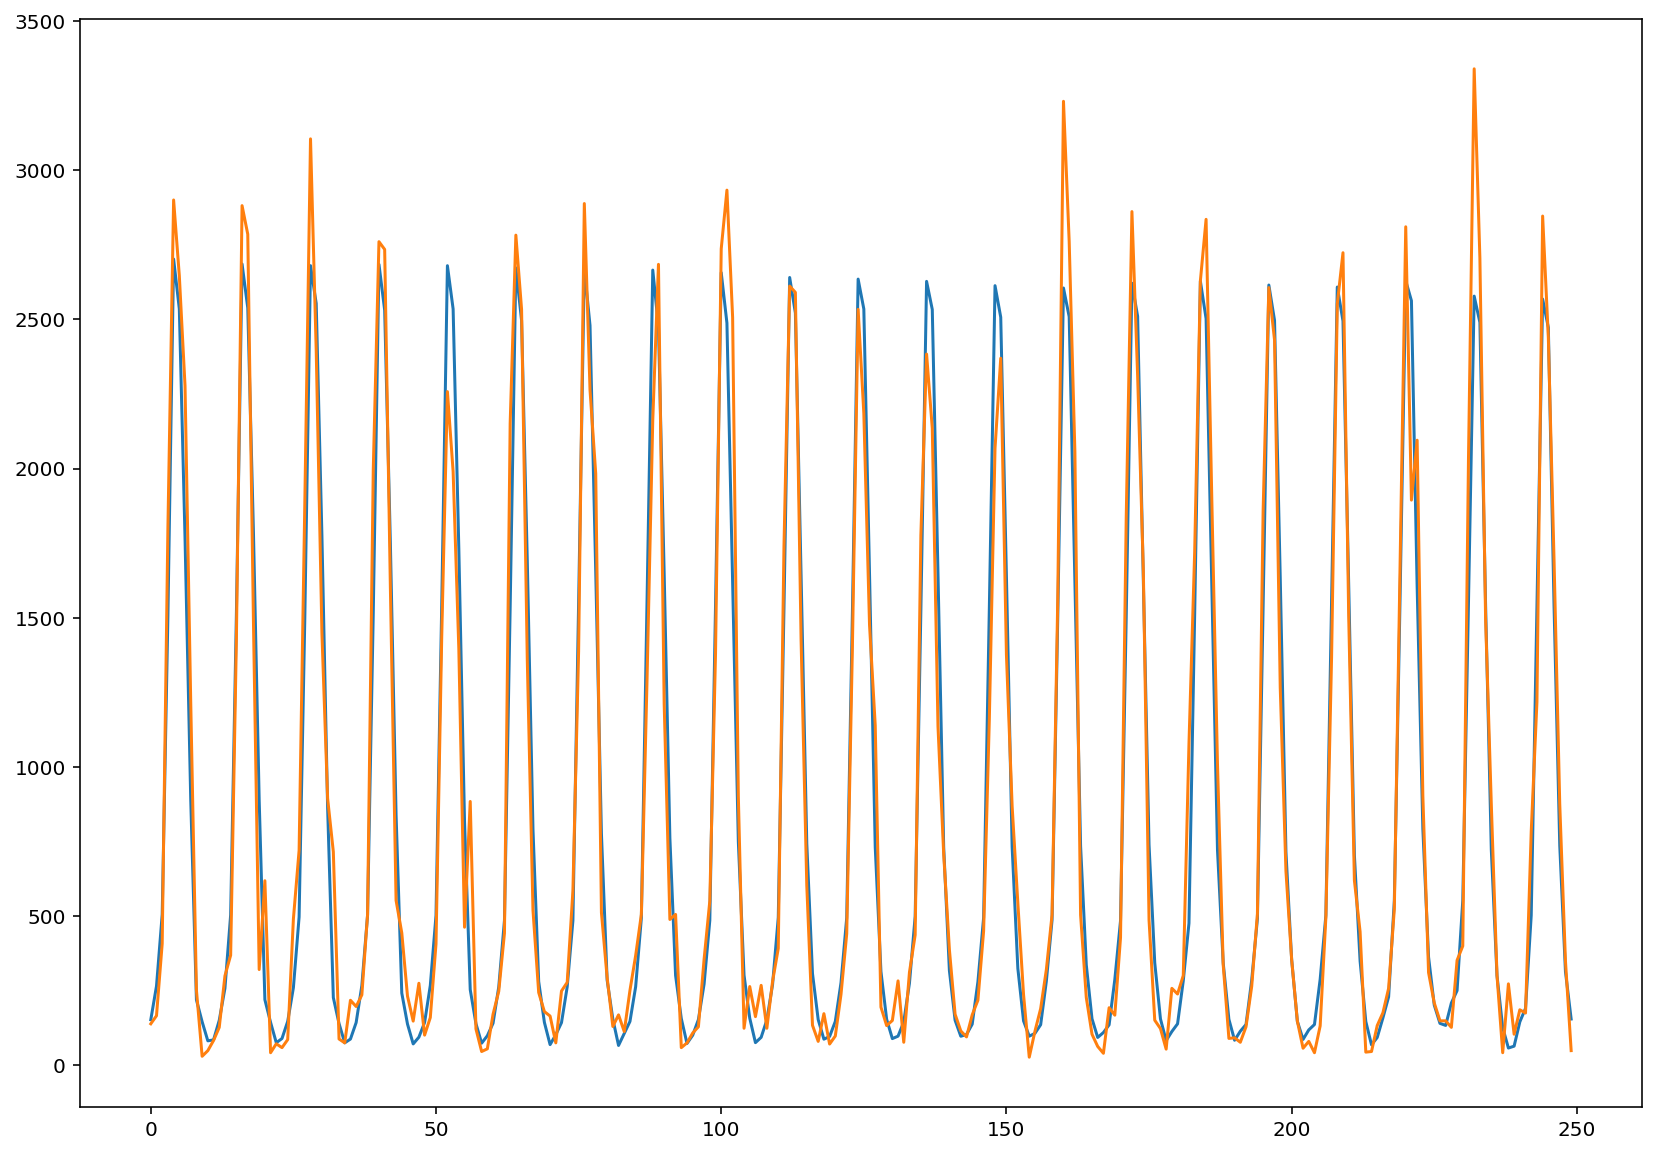

In [11]:
plt.plot(preds)
plt.plot(data.ts[-data.test.size:]);

In [13]:
getRMSE(data.ts[-data.test.size:], preds.reshape(-1))

223.14831357417265

In [38]:
def search_ssa_params_rec(folder: str, path: str = 'data/ssa_res/reconstruct/',  **kwargs) -> tuple:
    results = []
    # ssa{})
    
    for L in kwargs['L']:
        for r in kwargs['r']:
            if (L > r):
                ssa = edict({
                    'L' : L,
                    'ssa_groups' : list(range(1, r+1)),
                    'rssa' : kwargs['rssa']
                })
                signal_estimation = applySSA(kwargs['train'], ssa)
                error = getRMSE(signal_estimation, kwargs['sig'])
                results.append([error, L, r])
    
    dfRes = pd.DataFrame(results, columns = ['rmse', 'L', 'r'])
    dfRes = dfRes.sort_values('rmse')
    
    if folder[-1] != '/':
        folder += '/'
    dfRes.to_csv(f'{path}{folder}results.csv', sep = ';', index=False)
    
    with open(f'{path}{folder}info.txt', 'w') as f:
        f.write(f"TRAIN_SIZE: {len(kwargs['train'])} \n")
        f.write(f"L list: {kwargs['L']} \n")
        f.write(f"r list: {kwargs['r']} \n \n")
        
    return results

In [47]:
res = search_ssa_params_rec('ser_rec', train = ser[:TRAIN_SIZE], sig = ser_sig[:TRAIN_SIZE], L = Ls, r = [2, 4, 6, 8, 12, 16, 18], rssa = rssa)

***

In [50]:
rmse = 1000000

temp = res[2]
# res7 = []
# for r in temp:
#     if 12 == r[2] and r[0] < rmse:
#         res7.append(r)
#         rmse = r[0]
# res75 = res7[-5:]
df = pd.DataFrame(temp)
df_temp = df#[df[2] == 12]
res75 = df_temp.sort_values(0).iloc[:5,].to_numpy()

In [ ]:
df_temp.sort_values(0).iloc[:5,]

NameError: name 'df_temp' is not defined

In [41]:
res75

array([[5.899789184417491, 120, 5, 'recurrent'],
       [5.905572443061727, 108, 5, 'recurrent'],
       [5.907978766970222, 132, 5, 'recurrent'],
       [5.909655173622592, 72, 5, 'recurrent'],
       [5.916835518839975, 84, 5, 'recurrent']], dtype=object)

In [134]:
np.unique(df.L)

array([ 12,  24,  36,  48,  60,  72,  84,  96, 108, 120, 132, 144, 156,
       168])

0       True
1       True
2       True
3       True
4       True
       ...  
123     True
124    False
125    False
126    False
127     True
Name: r, Length: 128, dtype: bool

In [117]:
~((df['L'] == 12)*(df['r'] == 11))

0       True
1       True
2       True
3       True
4       True
       ...  
123     True
124     True
125     True
126     True
127    False
Length: 128, dtype: bool

In [15]:
folder = 'ser/'

df = pd.read_csv(f'data/ssa_res/{folder}/results.csv', delimiter=';')
#df = df[df['r'] == 4]
#df = df.sort_values('rmse').iloc[:5]
#df = df.iloc[1:]
df #= df[~((df['L'] == 12)*(df['r'] == 11))]

,rmse,L,r,method
0,0.000000,12,12,recurrent
1,1.611026,36,16,recurrent
2,1.614566,24,10,recurrent
3,1.653207,24,12,recurrent
4,1.663535,96,16,recurrent
...,...,...,...,...
105,2.627527,84,2,recurrent
106,2.635124,60,2,recurrent
107,2.662972,72,2,recurrent
108,2.732060,12,2,recurrent


In [49]:
np.unique(df.L)

array([ 12,  24,  36,  48,  60,  72,  84,  96, 108, 120, 132, 144, 156,
       168, 175])

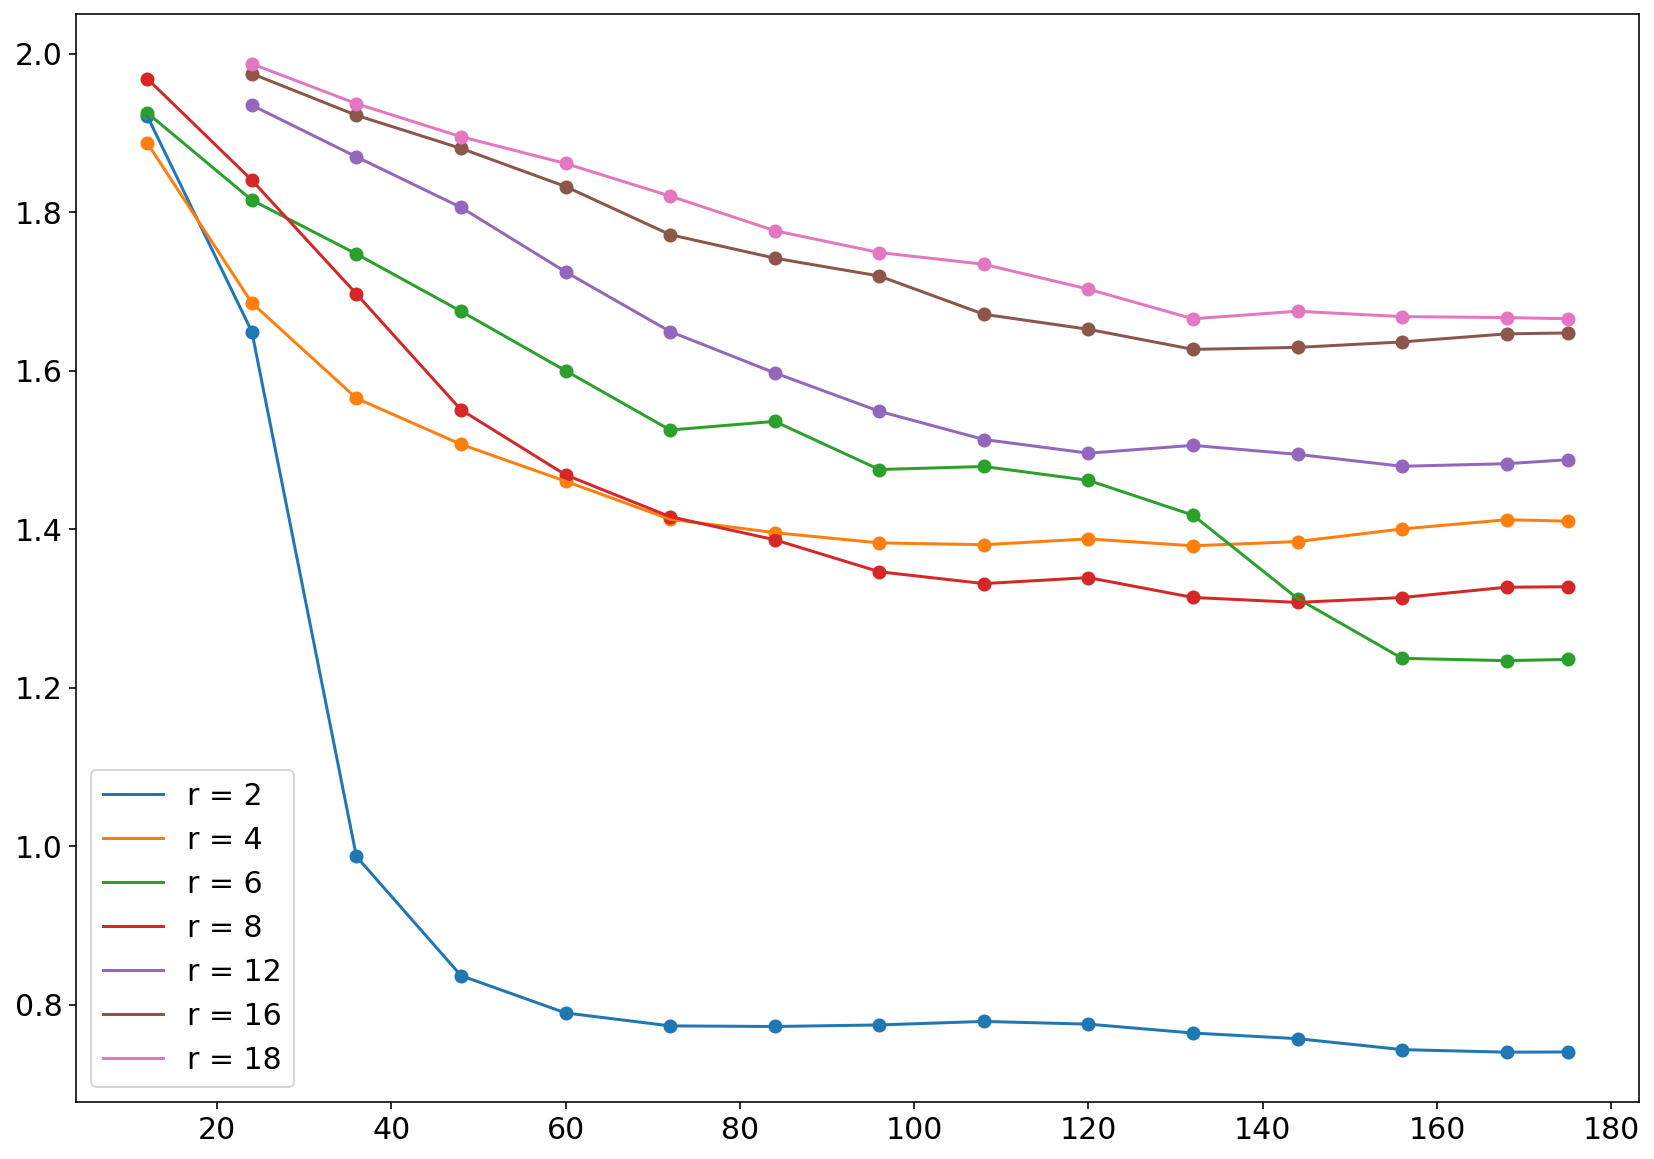

In [50]:
rc('xtick', labelsize=15) 
rc('ytick', labelsize=15)
rc('legend',fontsize=15)


for r in np.unique(df.r):
    df_plot = df.sort_values('L')[df.sort_values('L').r == r]
    #plt.xticks(np.unique(df.L))
    plt.scatter(df_plot.L, df_plot.rmse)
    plt.plot(df_plot.L, df_plot.rmse, label = 'r = ' + str(r))
plt.legend()
    #

In [17]:
res75 = df.to_numpy()[1:]
res75

array([[1.6110256945435375, 36, 16, 'recurrent'],
       [1.6145661725494822, 24, 10, 'recurrent'],
       [1.6532066128557694, 24, 12, 'recurrent'],
       [1.6635349768893026, 96, 16, 'recurrent'],
       [1.6675476590815017, 24, 8, 'recurrent'],
       [1.6692820829266584, 12, 6, 'recurrent'],
       [1.6813617571225443, 96, 14, 'recurrent'],
       [1.7005609101819228, 84, 14, 'recurrent'],
       [1.7034952214569814, 84, 12, 'recurrent'],
       [1.7057892142831663, 96, 10, 'recurrent'],
       [1.7076713353710964, 72, 14, 'recurrent'],
       [1.714163696831169, 96, 12, 'recurrent'],
       [1.7224587885891989, 108, 16, 'recurrent'],
       [1.7315568335703508, 60, 12, 'recurrent'],
       [1.7343980647259818, 24, 14, 'recurrent'],
       [1.738553196859832, 48, 16, 'recurrent'],
       [1.742810383859556, 120, 16, 'recurrent'],
       [1.7434288666480062, 84, 16, 'recurrent'],
       [1.7438630674472575, 84, 10, 'recurrent'],
       [1.754556621965782, 36, 10, 'recurrent'],
    

In [22]:
res75[:5]

array([[1.6110256945435375, 36, 16, 'recurrent'],
       [1.6145661725494822, 24, 10, 'recurrent'],
       [1.6532066128557694, 24, 12, 'recurrent'],
       [1.6635349768893026, 96, 16, 'recurrent'],
       [1.6675476590815017, 24, 8, 'recurrent']], dtype=object)

In [23]:
results = {}
for r in res75[:5]:
    print(r)
    preds = predict_array_by_ssa(data.ts[-data.test.size-data.train.size:-data.test.size], data.ts[-data.test.size:], r[1], r[2], 'recurrent', rssa)
    results.update({(r[1], r[2]) : np.sqrt(
    ((preds.reshape(-1) - test)**2).mean()
)})

[1.6110256945435375 36 16 'recurrent']
[1.6145661725494822 24 10 'recurrent']
[1.6532066128557694 24 12 'recurrent']
[1.6635349768893026 96 16 'recurrent']
[1.6675476590815017 24 8 'recurrent']


In [24]:
# ser 17.05
results

{(36, 16): 1.8308863030497065,
 (24, 10): 1.7327355718357502,
 (24, 12): 1.8369393647331844,
 (96, 16): 1.9615531101003072,
 (24, 8): 1.832340703954742}

In [40]:
# edsine 0.3 r = 2
results

{132: 0.7891557983830271}

In [42]:
# edsine 0.3 r = 4
results

{132: 0.31861211035118936}

In [44]:
# edsine 0.3 r = 6
results

{132: 0.32798001544429883}

In [189]:
# edsine r = 2
results

{117: 1.7123370140317977,
 104: 1.7123370140317977,
 143: 1.7123370140317977,
 156: 1.7123370140317977,
 91: 1.7123370140317977}

In [191]:
# edsine r = 4
results

{117: 1.6057291680532535,
 104: 1.6057291680532535,
 143: 1.6057291680532535,
 156: 1.6057291680532535,
 91: 1.6057291680532535}

In [193]:
# edsine r = 6
results

{117: 1.6521232452698609,
 104: 1.6521232452698609,
 143: 1.6521232452698609,
 156: 1.6521232452698609,
 91: 1.6521232452698609}

In [44]:
# tsSin 620 r = 12 L = LH
results

{117: 10.086907490303442,
 104: 9.967405746824383,
 143: 10.273373802055417,
 156: 10.502465965781647,
 91: 10.086132120539721}

In [217]:
# x_pole_no_trend
results

{26: 0.009982417393572482,
 52: 0.018163735297652712,
 39: 0.016021811890728852,
 78: 0.02145938976277069,
 65: 0.021021842451691718}

In [233]:
# indian rain
results

{180: 223.788817087436,
 192: 224.05505464261842,
 204: 224.0414201562979,
 168: 223.07204718431257,
 216: 224.1642503033569}

In [28]:
# ser
results

{26: 1.6090017531398464,
 91: 2.075896420151069,
 78: 2.1444993198633595,
 65: 1.942712393658355,
 39: 1.6771511669582748}

In [52]:
#tsSin r2
results

{143: 3.2864071220669957,
 130: 3.333380276293192,
 117: 3.5945469809876736,
 104: 3.7884520486646505,
 156: 3.6480183597584843}

In [31]:
#tsSin
results

{182: 10.192423720864452,
 169: 10.212086337965417,
 195: 10.15785046052862,
 130: 10.140111829794275,
 156: 10.347141276747065}

In [263]:
# x_pole_no_trend Входной
results

{312: 0.01167357746070865,
 299: 0.011673141800861191,
 273: 0.011692897937819174,
 286: 0.011708551207175009,
 221: 0.01182152044796984}

In [43]:
# weather 
results

{120: 5.666157583032649,
 108: 5.635934028480847,
 132: 5.615262796625373,
 72: 5.645488752158603,
 84: 5.654392011752892}

# SSA reconstruct

([1, 2, 3, 4], 175, [1, 2, 3, 4, 5, 6], 175)

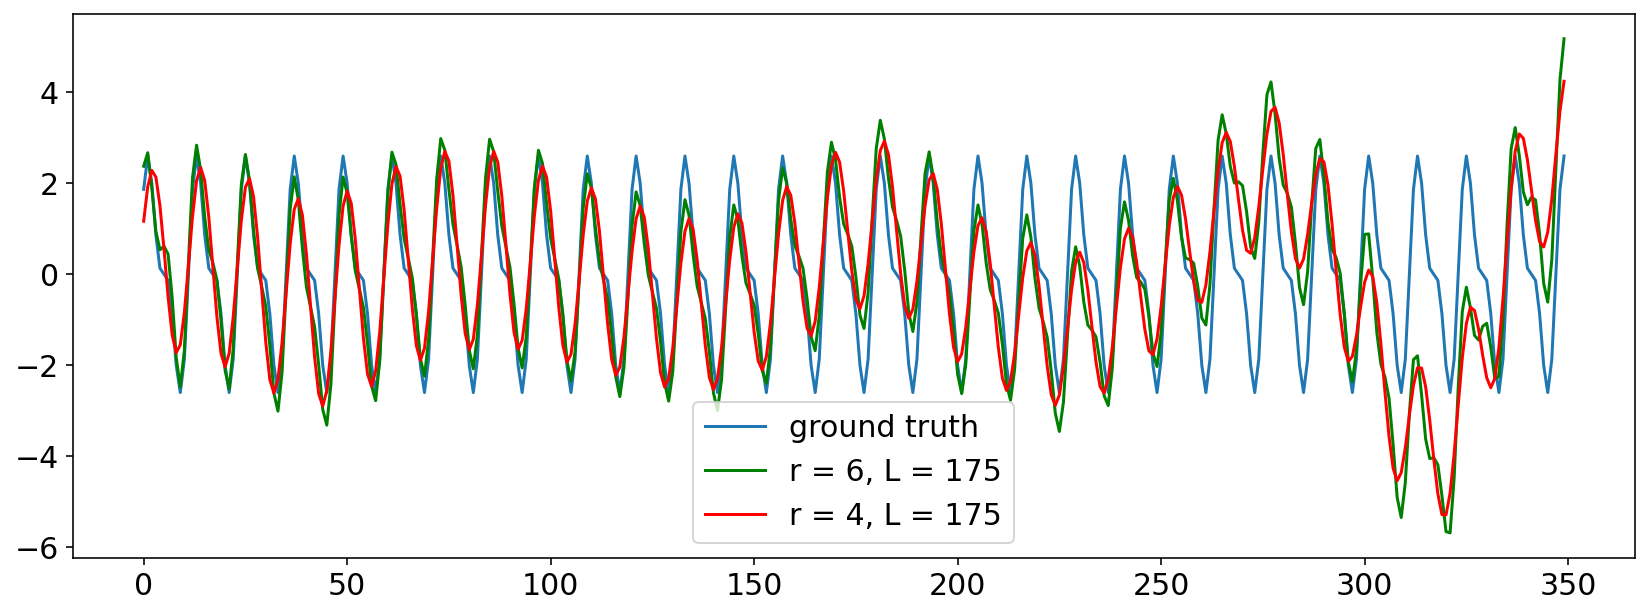

In [70]:
ssa1 = edict({
    'L' : TRAIN_SIZE//2,
    'ssa_groups' : list(range(1,5)), #[1,2,3,4,5,6,7],
    'rssa' : rssa
})

ssa2 = edict({
    'L' : TRAIN_SIZE//2,
    'ssa_groups' : list(range(1,7)), #[1,2,3,4,5,6,7],
    'rssa' : rssa
})


ts = ser
signal = ser_sig
plt.figure(figsize=(14, 5))
rc('xtick', labelsize=15) 
rc('ytick', labelsize=15) 
plt.plot(signal[:TRAIN_SIZE], label = 'ground truth');
plt.plot(applySSA(ts[:TRAIN_SIZE], ssa2), color = 'green', label = f'r = {ssa2.ssa_groups[-1]}, L = {ssa2.L}')
plt.plot(applySSA(ts[:TRAIN_SIZE], ssa1), color = 'red', label = f'r = {ssa1.ssa_groups[-1]}, L = {ssa1.L}')
plt.legend()
ssa1.ssa_groups, ssa1.L, ssa2.ssa_groups, ssa2.L

([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 84)

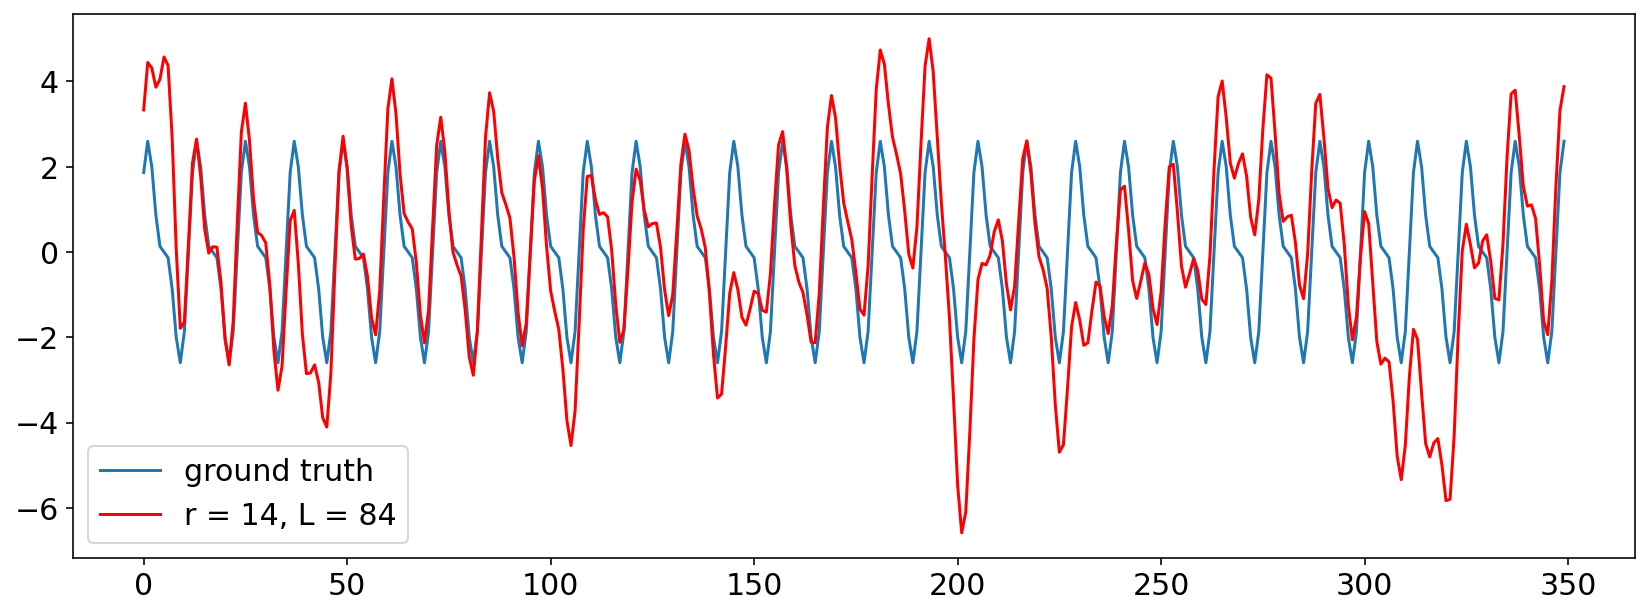

In [67]:
ssa = edict({
    'L' : 84,
    'ssa_groups' : list(range(1,15)), #[1,2,3,4,5,6,7],
    'rssa' : rssa
})


ts = ser
signal = ser_sig
plt.figure(figsize=(14, 5))
rc('xtick', labelsize=15) 
rc('ytick', labelsize=15) 
plt.plot(signal[:TRAIN_SIZE], label = 'ground truth');
plt.plot(applySSA(ts[:TRAIN_SIZE], ssa), color = 'red', label = f'r = {ssa.ssa_groups[-1]}, L = {ssa.L}')
plt.legend()
ssa.ssa_groups, ssa.L

In [59]:
ssa = edict({
    'L' : TRAIN_SIZE//2,
    'ssa_groups' : list(range(1,12)), #[1,2,3,4,5,6,7],
    'rssa' : rssa
})

ts = rain_m
signal = rain_m
plt.figure(figsize=(14, 5))
rc('xtick', labelsize=15) 
rc('ytick', labelsize=15) 
plt.plot(signal[:TRAIN_SIZE], label = 'ground truth');
plt.plot(applySSA(ts[:TRAIN_SIZE], ssa), color = 'green', label = f'r = {ssa.ssa_groups[-1]}, L = {ssa.L}')
plt.legend()
ssa.ssa_groups, ssa.L

NameError: name 'rain_m' is not defined

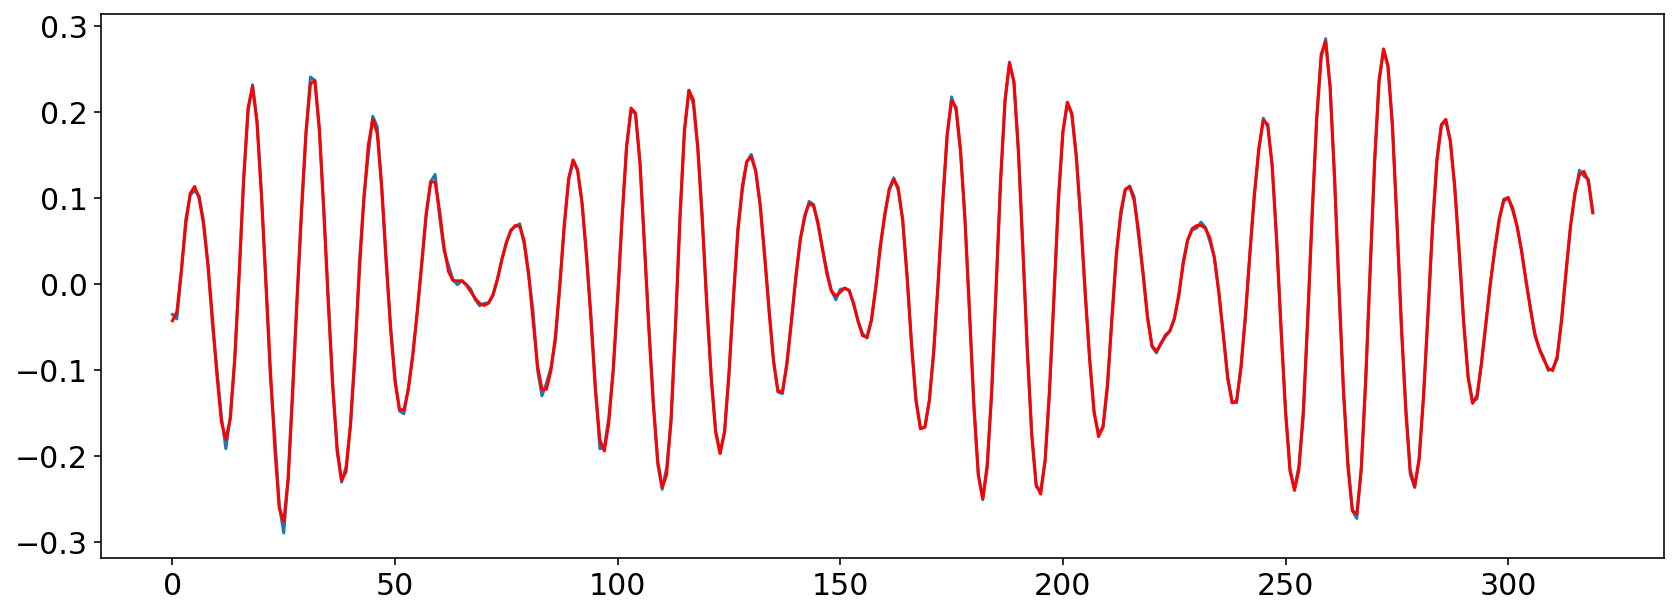

In [303]:
ssa = edict({
    'L' : 26,
    'ssa_groups' : list(range(1,13)), #[1,2,3,4,5,6,7],
    'rssa' : rssa
})

plt.figure(figsize=(14, 5))
rc('xtick', labelsize=15) 
rc('ytick', labelsize=15) 

ssa_sig = applySSA(train, ssa)
plt.plot(train)
plt.plot(ssa_sig, color = 'red')

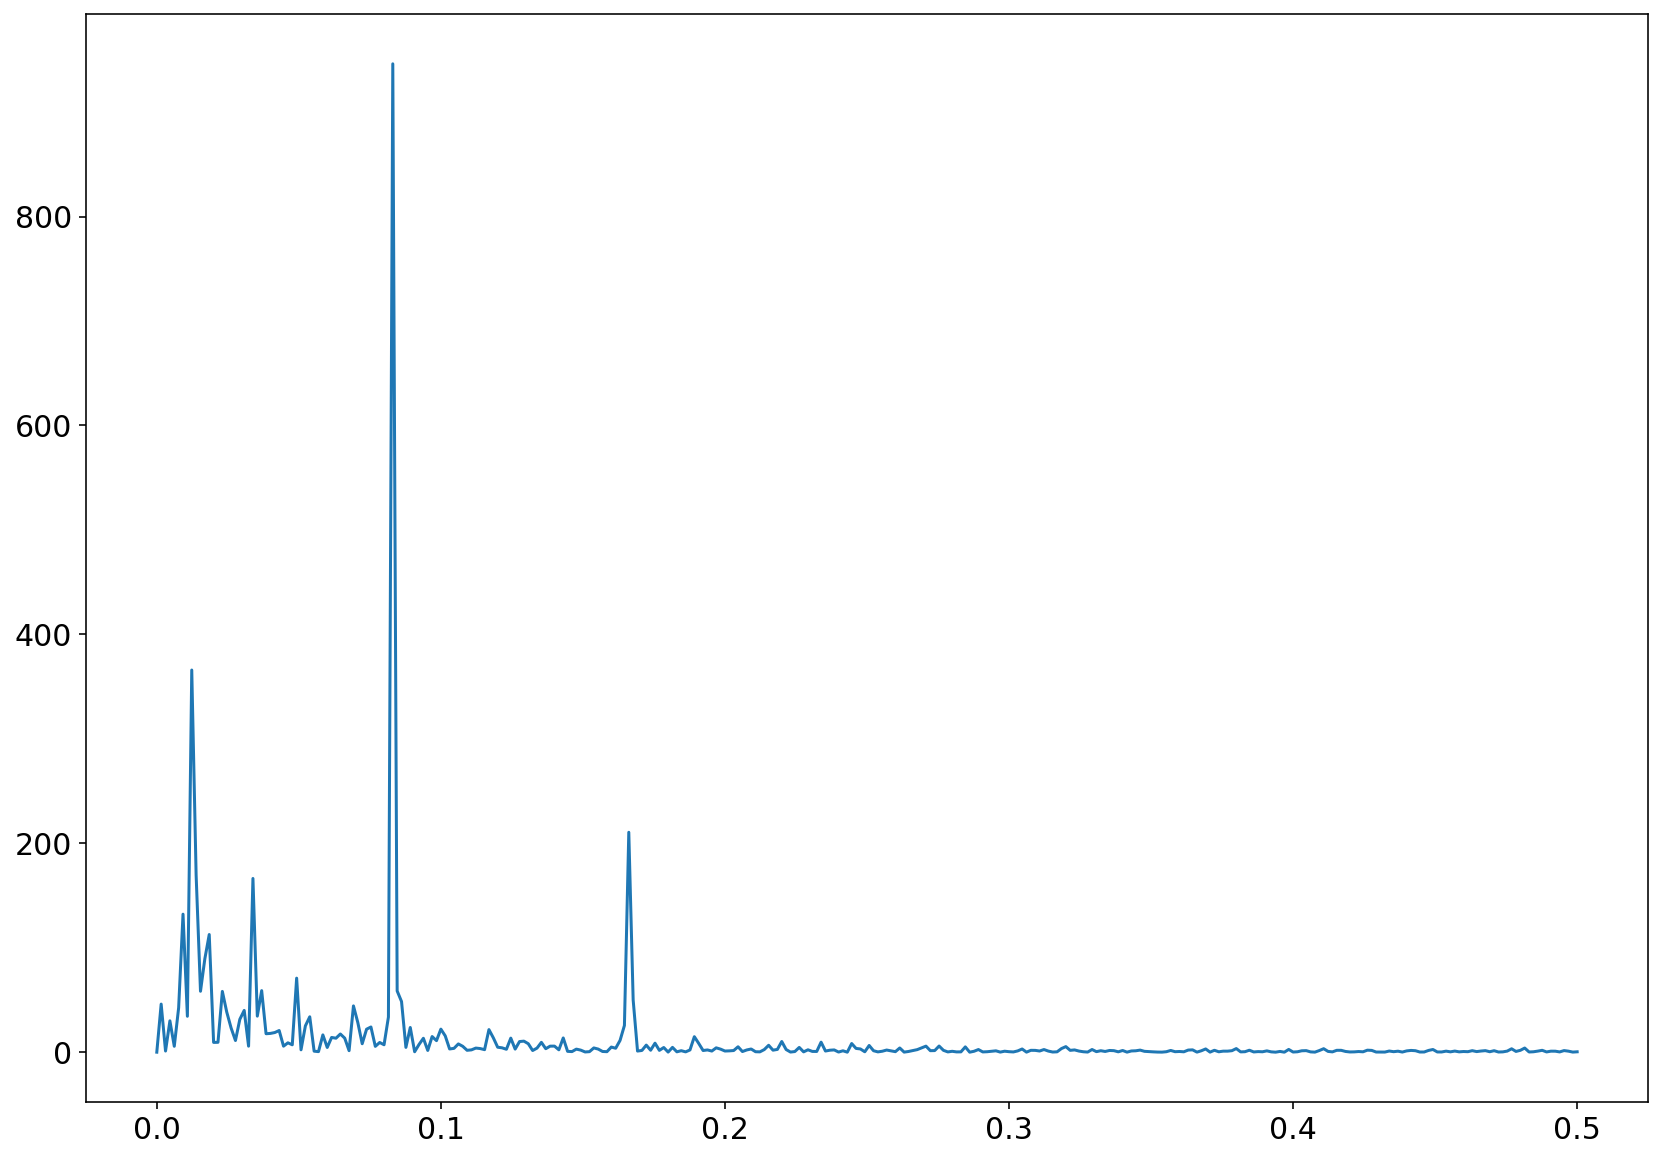

In [20]:
# plt.figure(figsize=(14, 5))
# rc('xtick', labelsize=15) 
# rc('ytick', labelsize=15) 

x = periodogram(ser)
plt.plot(x[0], x[1])

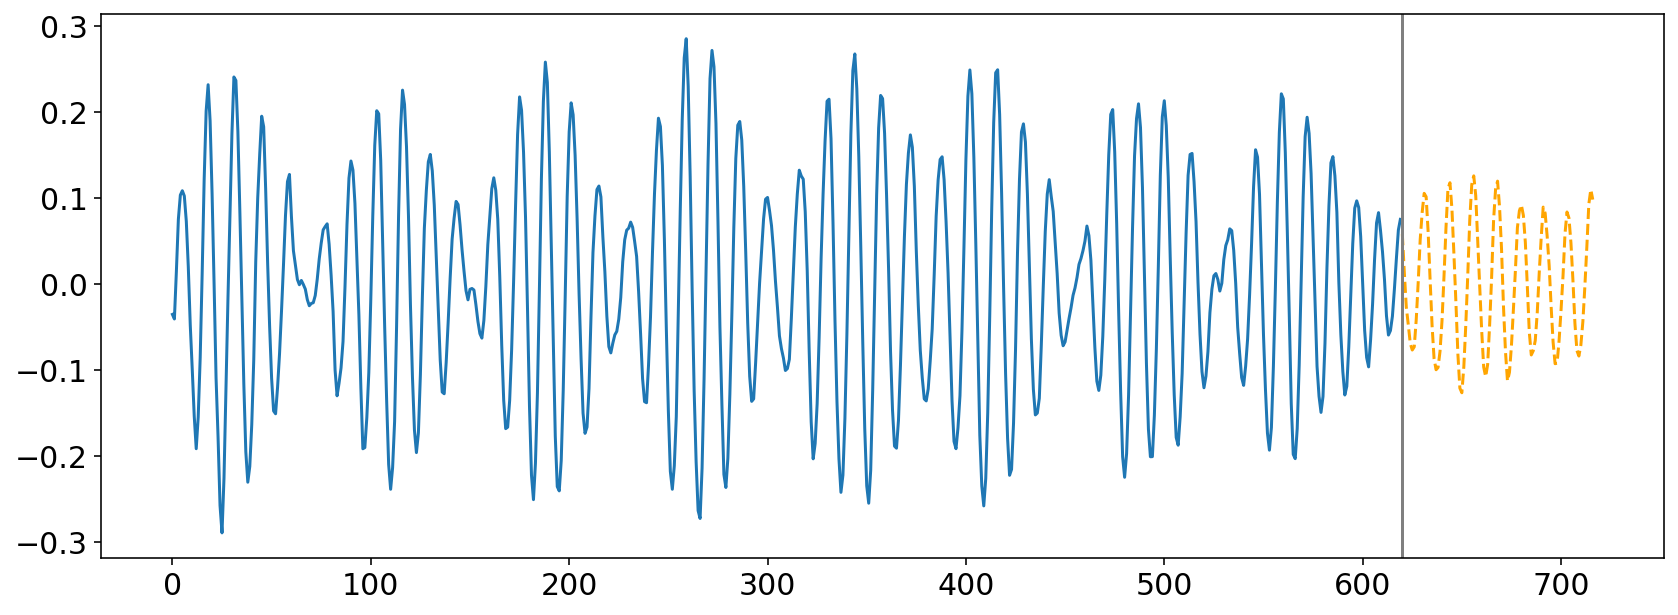

In [34]:
plt.figure(figsize=(14, 5))
rc('xtick', labelsize=15) 
rc('ytick', labelsize=15) 

plt.plot(x_pole_ts[:620])
plt.plot(np.arange(620, 620 + len(x_pole_ts[620:])), x_pole_ts[620:], color='orange', linestyle='dashed')
plt.axvline(x=620, color='grey')

In [16]:
res = ((120, 5, 'recurrent'),
 5.899789184417491,
 [(6.928470963764293, 12, 3, 'recurrent'),
  (6.83947591183979, 12, 5, 'recurrent'),
  (9.41773125493317, 12, 7, 'recurrent'),
  (18.213935633767527, 12, 9, 'recurrent'),
  (45.78964639120092, 12, 11, 'recurrent'),
  (6.48040921870357, 24, 3, 'recurrent'),
  (6.514020605275014, 24, 5, 'recurrent'),
  (6.464771207390981, 24, 7, 'recurrent'),
  (6.883063956157154, 24, 9, 'recurrent'),
  (6.774589428426474, 24, 11, 'recurrent'),
  (6.883367468539615, 24, 13, 'recurrent'),
  (6.352903305171197, 36, 3, 'recurrent'),
  (6.136695879928465, 36, 5, 'recurrent'),
  (6.402413641288938, 36, 7, 'recurrent'),
  (6.514950713610466, 36, 9, 'recurrent'),
  (6.52428453639975, 36, 11, 'recurrent'),
  (6.705286905096853, 36, 13, 'recurrent'),
  (6.294642480468138, 48, 3, 'recurrent'),
  (6.023477591286586, 48, 5, 'recurrent'),
  (6.314307441223745, 48, 7, 'recurrent'),
  (6.476813356077393, 48, 9, 'recurrent'),
  (6.5686808808750365, 48, 11, 'recurrent'),
  (6.555875621124704, 48, 13, 'recurrent'),
  (6.231645642604302, 60, 3, 'recurrent'),
  (5.9236571913827625, 60, 5, 'recurrent'),
  (6.246115615039399, 60, 7, 'recurrent'),
  (6.535271678000702, 60, 9, 'recurrent'),
  (6.74130957495957, 60, 11, 'recurrent'),
  (6.698628011610986, 60, 13, 'recurrent'),
  (6.238632071566224, 72, 3, 'recurrent'),
  (5.909655173622592, 72, 5, 'recurrent'),
  (6.27923349833514, 72, 7, 'recurrent'),
  (6.689490938099841, 72, 9, 'recurrent'),
  (6.7242979433543155, 72, 11, 'recurrent'),
  (6.921166232356237, 72, 13, 'recurrent'),
  (6.2438483382675, 84, 3, 'recurrent'),
  (5.916835518839975, 84, 5, 'recurrent'),
  (6.207978954833704, 84, 7, 'recurrent'),
  (6.563873430044256, 84, 9, 'recurrent'),
  (6.566821461697286, 84, 11, 'recurrent'),
  (6.658562882730493, 84, 13, 'recurrent'),
  (6.25688419947485, 96, 3, 'recurrent'),
  (5.926982195218694, 96, 5, 'recurrent'),
  (6.236974580581736, 96, 7, 'recurrent'),
  (6.36361926146621, 96, 9, 'recurrent'),
  (6.376914916286403, 96, 11, 'recurrent'),
  (6.606401408932108, 96, 13, 'recurrent'),
  (6.2514041796698026, 108, 3, 'recurrent'),
  (5.905572443061727, 108, 5, 'recurrent'),
  (6.18697031040379, 108, 7, 'recurrent'),
  (6.350568447790992, 108, 9, 'recurrent'),
  (6.4416308073313475, 108, 11, 'recurrent'),
  (6.469180021738671, 108, 13, 'recurrent'),
  (6.234333643622631, 120, 3, 'recurrent'),
  (5.899789184417491, 120, 5, 'recurrent'),
  (6.144235912069754, 120, 7, 'recurrent'),
  (6.321148512217813, 120, 9, 'recurrent'),
  (6.416356127778518, 120, 11, 'recurrent'),
  (6.433800810655822, 120, 13, 'recurrent'),
  (6.239875745605582, 132, 3, 'recurrent'),
  (5.907978766970222, 132, 5, 'recurrent'),
  (6.112745129657135, 132, 7, 'recurrent'),
  (6.29609010764075, 132, 9, 'recurrent'),
  (6.328278293665459, 132, 11, 'recurrent'),
  (6.497792633888153, 132, 13, 'recurrent'),
  (6.247541120702245, 144, 3, 'recurrent'),
  (5.923386549432211, 144, 5, 'recurrent'),
  (6.099230643407838, 144, 7, 'recurrent'),
  (6.2337276290743535, 144, 9, 'recurrent'),
  (6.270207689397143, 144, 11, 'recurrent'),
  (6.310349342374381, 144, 13, 'recurrent'),
  (6.263522261212139, 156, 3, 'recurrent'),
  (5.954017009010791, 156, 5, 'recurrent'),
  (6.176954323072281, 156, 7, 'recurrent'),
  (6.250403210965962, 156, 9, 'recurrent'),
  (6.274442864485381, 156, 11, 'recurrent'),
  (6.3562358694671035, 156, 13, 'recurrent'),
  (6.289325076294165, 168, 3, 'recurrent'),
  (5.9929705597068885, 168, 5, 'recurrent'),
  (6.2789667052968205, 168, 7, 'recurrent'),
  (6.322892180195438, 168, 9, 'recurrent'),
  (6.2157592871888285, 168, 11, 'recurrent'),
  (6.275193670197546, 168, 13, 'recurrent'),
  (6.294124516250018, 180, 3, 'recurrent'),
  (6.000093811457871, 180, 5, 'recurrent'),
  (6.288716337977853, 180, 7, 'recurrent'),
  (6.342423179506615, 180, 9, 'recurrent'),
  (6.293310759311644, 180, 11, 'recurrent'),
  (6.274900096857821, 180, 13, 'recurrent'),
  (6.312318317611089, 192, 3, 'recurrent'),
  (6.038658351515953, 192, 5, 'recurrent'),
  (6.305075881807361, 192, 7, 'recurrent'),
  (6.377665091818053, 192, 9, 'recurrent'),
  (6.265763034425228, 192, 11, 'recurrent'),
  (6.2590473548802095, 192, 13, 'recurrent'),
  (6.327677624918716, 204, 3, 'recurrent'),
  (6.044642236613494, 204, 5, 'recurrent'),
  (6.308943469689316, 204, 7, 'recurrent'),
  (6.3316891872322465, 204, 9, 'recurrent'),
  (6.305969445684815, 204, 11, 'recurrent'),
  (6.31215939291778, 204, 13, 'recurrent'),
  (6.326991503256235, 216, 3, 'recurrent'),
  (6.040981509573781, 216, 5, 'recurrent'),
  (6.20312370501123, 216, 7, 'recurrent'),
  (6.335502080510216, 216, 9, 'recurrent'),
  (6.2785872668661336, 216, 11, 'recurrent'),
  (6.337054729650033, 216, 13, 'recurrent'),
  (6.3103832522415395, 228, 3, 'recurrent'),
  (6.028359121910751, 228, 5, 'recurrent'),
  (6.182990274755644, 228, 7, 'recurrent'),
  (6.2958496585236885, 228, 9, 'recurrent'),
  (6.276999575962207, 228, 11, 'recurrent'),
  (6.420398763111687, 228, 13, 'recurrent'),
  (6.2779819506890115, 240, 3, 'recurrent'),
  (5.993997037397924, 240, 5, 'recurrent'),
  (6.183092610141604, 240, 7, 'recurrent'),
  (6.283013528640029, 240, 9, 'recurrent'),
  (6.341576879929871, 240, 11, 'recurrent'),
  (6.313893511674543, 240, 13, 'recurrent'),
  (6.290621056355418, 252, 3, 'recurrent'),
  (6.000361482216039, 252, 5, 'recurrent'),
  (6.171451279587417, 252, 7, 'recurrent'),
  (6.290630230809513, 252, 9, 'recurrent'),
  (6.350076534300981, 252, 11, 'recurrent'),
  (6.26898206289106, 252, 13, 'recurrent'),
  (6.276606406169651, 264, 3, 'recurrent'),
  (6.002750886730045, 264, 5, 'recurrent'),
  (6.16197873483143, 264, 7, 'recurrent'),
  (6.264257086737838, 264, 9, 'recurrent'),
  (6.340709300337551, 264, 11, 'recurrent'),
  (6.331559692608555, 264, 13, 'recurrent')])

In [20]:
pd.DataFrame(res[2], columns = ['rmse', 'L', 'r', 'method'])

,rmse,L,r,method
0,6.928471,12,3,recurrent
1,6.839476,12,5,recurrent
2,9.417731,12,7,recurrent
3,18.213936,12,9,recurrent
4,45.789646,12,11,recurrent
...,...,...,...,...
126,6.002751,264,5,recurrent
127,6.161979,264,7,recurrent
128,6.264257,264,9,recurrent
129,6.340709,264,11,recurrent
